# Info
Name:  

    COSR_DARE

Purpose:  

    To Build the COSR DARE calculations
  
Input:

    arguments
  
Output:

    Figure and save files
  
Keywords:

    none
  
Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - ...
  
Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2019-10-04
    Modified: 

# Prepare python environment

In [1]:
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
from path_utils import getpath
import hdf5storage as hs
import scipy.io as sio
from datetime import datetime
from scipy.interpolate import UnivariateSpline, interp1d
from scipy import interpolate 
import pandas as pd
import matplotlib.pyplot as plt
import Sun_utils as su

In [2]:
%matplotlib notebook

In [3]:
import Run_libradtran as RL
import os
import write_utils as wu
from tqdm.notebook import tqdm

In [4]:
name = 'COSR'
vv = 'v2'

In [5]:
fp =getpath('COSR')

Return path named:  COSR /data/sam/COSR/


In [193]:
day = '20180609'
#day = '20180618'
#day = '20180624'
#day = '20180625'


In [194]:
#get the paths
fp_rtm = getpath('rtm')
fpp_in = fp_rtm+'input/{}_{}_CRE_{}/'.format(name,day,vv)
fpp_out = fp_rtm+'output/{}_{}_CRE_{}/'.format(name,day,vv)
fp_uv = getpath('uvspecb')+'uvspec'
fp_librad = getpath('libradtranb')+'data/'

Return path named:  rtm /scratch/rtm/
Return path named:  uvspecb /home/sam/libradtran/libRadtran-2.0.2b/bin/
Return path named:  libradtranb /home/sam/libradtran/libRadtran-2.0.2b/


## Setup command line interface

In [8]:
import argparse

In [13]:
long_description = """    Prepare or save the direct Aerosol radiative effect files for calculations. """

In [14]:
parser = argparse.ArgumentParser(description=long_description)
parser.add_argument('-doread','--doread',help='if set, will only read the output, not produce them',
                    action='store_true')
parser.add_argument('-d','--daystr',nargs='?',help='The day string (yyyymmdd) for the desired flight data. Defaults to 20180624')

_StoreAction(option_strings=['-d', '--daystr'], dest='daystr', nargs='?', const=None, default=None, type=None, choices=None, help='The day string (yyyymmdd) for the desired flight data. Defaults to 20180624', metavar=None)

In [15]:
in_ = vars(parser.parse_args())
do_read = in_.get('doread',False)
day = in_.get('daystr','20180624')

usage: ipykernel_launcher.py [-h] [-doread] [-d [DAYSTR]]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/sam/.local/share/jupyter/runtime/kernel-83edc5e4-c217-457e-b044-8ae9b562c604.json


SystemExit: 2

/home/sam/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Load files

## Load the in situ files

In [270]:
situ = pd.read_csv(fp+'data_other/{}_nephclap.csv'.format(day))

In [196]:
situ

DateTimeUTC  totScat_450nm  totScatCalc_500nm  totScat_550nm  \
0      2018-06-09 15:00:00           2.43           2.217504           1.92   
1      2018-06-09 15:00:01           3.60           2.367144           1.31   
2      2018-06-09 15:00:02           2.75           2.314234           1.93   
3      2018-06-09 15:00:03           0.80           1.079652           1.71   
4      2018-06-09 15:00:04          -1.24                NaN           1.57   
5      2018-06-09 15:00:05          -0.84                NaN           3.03   
6      2018-06-09 15:00:06           1.54           1.860373           2.63   
7      2018-06-09 15:00:07           3.39           2.760472           2.34   
8      2018-06-09 15:00:08           3.94           3.105421           2.71   
9      2018-06-09 15:00:09           3.58                NaN           2.26   
10     2018-06-09 15:00:10           4.29           2.745681           2.58   
11     2018-06-09 15:00:11           3.60                NaN           2.62   
12     2018-06-09 15:00:12           4.16           2.681096           2.40   
13     2018-06-09 15:00:13           2.76                NaN           1.93   
14     2018-06-09 15:00:14           3.92           2.298952           1.52   
15     2018-06-09 15:00:15           2.66           2.304195           2.42   
16     2018-06-09 15:00:16           4.61           3.411050           2.59   
17     2018-06-09 15:00:17           4.15           3.124358           2.64   
18     2018-06-09 15:00:18           6.10           4.181259           2.91   
19     2018-06-09 15:00:19           4.19           3.138002           2.38   
20     2018-06-09 15:00:20           2.46           2.512597           2.82   
21     2018-06-09 15:00:21           1.31           1.600812           2.41   
22     2018-06-09 15:00:22           1.28           1.742372           2.91   
23     2018-06-09 15:00:23           1.26           1.722983           2.71   
24     2018-06-09 15:00:24           2.59           2.321178           1.93   
25     2018-06-09 15:00:25           4.19           1.969053           0.54   
26     2018-06-09 15:00:26           3.35           1.940796           0.76   
27     2018-06-09 15:00:27           4.20           2.627297           1.34   
28     2018-06-09 15:00:28           4.15           2.404385           1.10   
29     2018-06-09 15:00:29           6.33           3.258711           1.33   
...                    ...            ...                ...            ...   
19571  2018-06-09 20:26:11           4.05           2.126216           0.79   
19572  2018-06-09 20:26:12           4.29           2.780814           1.50   
19573  2018-06-09 20:26:13           2.67           0.991901           0.36   
19574  2018-06-09 20:26:14           3.85                NaN           2.38   
19575  2018-06-09 20:26:15           2.37           1.627879           1.76   
19576  2018-06-09 20:26:16           3.88           2.684890           2.56   
19577  2018-06-09 20:26:17           3.61                NaN           1.06   
19578  2018-06-09 20:26:18           3.69                NaN           1.59   
19579  2018-06-09 20:26:19           1.30                NaN           1.09   
19580  2018-06-09 20:26:20           1.09           1.562568           2.50   
19581  2018-06-09 20:26:21           0.67           0.965504           1.49   
19582  2018-06-09 20:26:22           1.07           1.677347           2.96   
19583  2018-06-09 20:26:23           6.56           3.266847           2.03   
19584  2018-06-09 20:26:24           2.49           2.703575           3.09   
19585  2018-06-09 20:26:25           2.56           2.077859           2.11   
19586  2018-06-09 20:26:26           1.54           1.683413           1.69   
19587  2018-06-09 20:26:27           2.38                NaN           2.68   
19588  2018-06-09 20:26:28           2.69                NaN           2.17   
19589  2018-06-09 20:26:29           3.18                NaN     

In [271]:
insitu = situ.to_dict('list')

In [272]:
insitu.keys()

['totScat_450nm',
 'totScat_700nm',
 'scatFitSlope',
 'totScat_550nm',
 'totAbs_528nm',
 'totAbs_467nm',
 'totAbsCalc_500nm',
 'totAbs_652nm',
 'totScatCalc_500nm',
 'DateTimeUTC',
 'angScat',
 'angAbs',
 'absFitSlope',
 'extCalc500nm',
 'absFitIncpt',
 'scatFitIncpt']

In [273]:
insitu['ssa_500nm'] = np.array(insitu['totScatCalc_500nm'])/np.array(insitu['extCalc500nm'])

In [274]:
insitu['extCalc500nm'] = np.array(insitu['extCalc500nm'])/10.0

In [275]:
gu = pd.to_datetime(situ['DateTimeUTC']).to_list()
insitu['utc'] = np.array([g.hour+g.minute/60.0+g.second/3600.0 for g in gu])

<IPython.core.display.Javascript object>


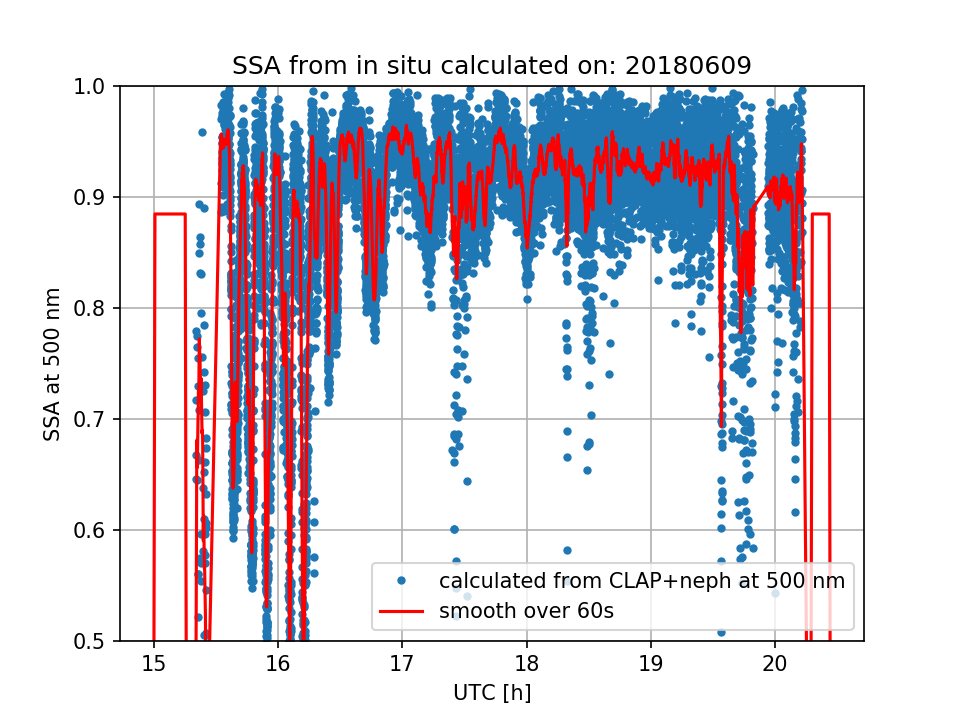

In [276]:
plt.figure()
plt.plot(insitu['utc'],insitu['ssa_500nm'],'.',label='calculated from CLAP+neph at 500 nm')
plt.plot(insitu['utc'],Sp.smooth(insitu['ssa_500nm'],60,old=True),'-r',label='smooth over 60s')
plt.legend()
plt.xlabel('UTC [h]')
plt.ylabel('SSA at 500 nm')
plt.title('SSA from in situ calculated on: {}'.format(day))
plt.ylim(0.5,1.0)
plt.grid()
plt.savefig(fp+'plots/SSA_500_CLAP_neph_smooth_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


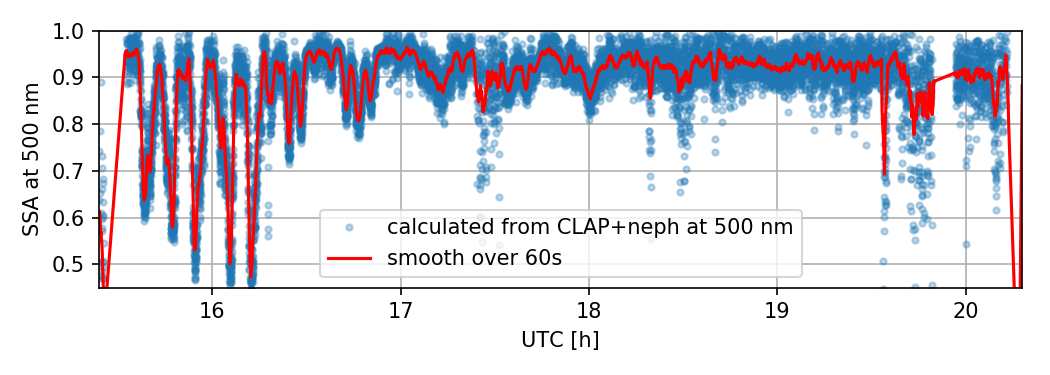

In [634]:
plt.figure(figsize=(7,2.5))
plt.plot(insitu['utc'],insitu['ssa_500nm'],'.',alpha=0.3,label='calculated from CLAP+neph at 500 nm')
plt.plot(insitu['utc'],Sp.smooth(insitu['ssa_500nm'],60,old=True),'-r',label='smooth over 60s')
plt.legend()
plt.xlabel('UTC [h]')
plt.ylabel('SSA at 500 nm')
#plt.title('SSA from in situ calculated on: {}'.format(day))
plt.ylim(0.45,1.0)
plt.xlim(15.4,20.3)
plt.grid()
plt.tight_layout()
plt.savefig(fp+'plots/SSA_500_CLAP_neph_smooth_transp_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

In [277]:
ssa_insitu = Sp.smooth(insitu['ssa_500nm'],60,old=True)

In [278]:
len(ssa_insitu)

19601

## Load the UHSAS files

In [279]:
uh = sio.loadmat(fp+'data_other/{}_UHSAS_ECCC.mat'.format(day))

In [280]:
uh.keys()

['None',
 '__globals__',
 '__function_workspace__',
 'instr',
 '__header__',
 'binDataConc',
 't',
 '__version__',
 'binFrom',
 'binTo']

In [281]:
uh['utc'] = lu.toutc(lu.mat2py_time(uh['t']))

In [282]:
uh['utc'].shape

(18391,)

In [283]:
uh['binDataConc'].sum(axis=1).shape

(18391,)

In [284]:
uh['nConc'] = uh['binDataConc'].sum(axis=1)

<IPython.core.display.Javascript object>


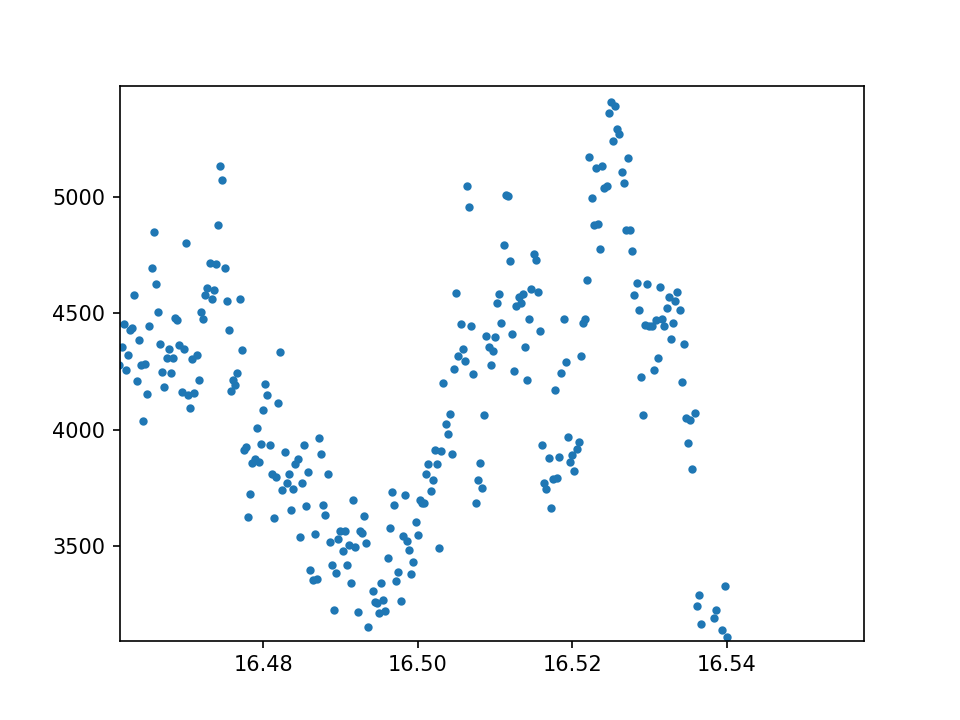

In [452]:
plt.figure()
plt.plot(uh['utc'],uh['binDataConc'].sum(axis=1),'.')

### Build a file for quick mie calculations

In [462]:
np.argmin(abs(uh['utc']-16.527))

5770

In [454]:
uh['binDataConc'].shape

(18391, 99)

<IPython.core.display.Javascript object>


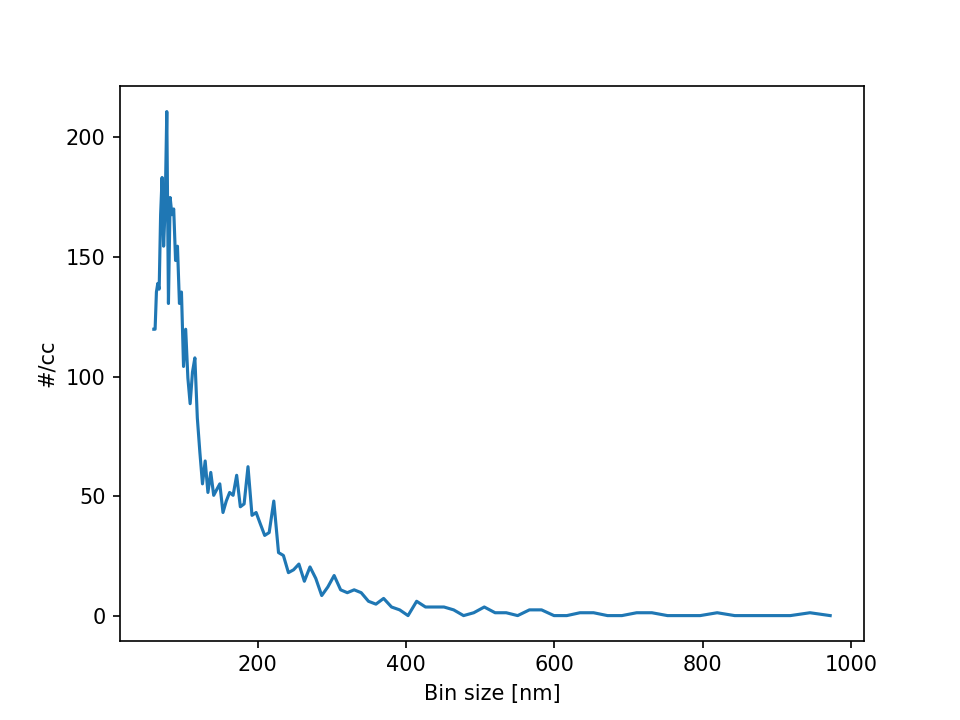

Text(0,0.5,'#/cc')

In [463]:
plt.figure()
plt.plot(uh['binFrom'][0,:],uh['binDataConc'][5770,:])
plt.xlabel('Bin size [nm]')
plt.ylabel('#/cc')

In [466]:
bin_averages = (uh['binFrom'][0,:] +uh['binTo'][0,:])/2.0/1000.0 #in micron

In [467]:
bin_averages 

array([0.060865, 0.06262 , 0.064425, 0.06628 , 0.06819 , 0.070155,
       0.07218 , 0.074265, 0.076405, 0.078605, 0.08087 , 0.0832  ,
       0.0856  , 0.08807 , 0.090605, 0.093215, 0.095905, 0.09867 ,
       0.101515, 0.10444 , 0.10745 , 0.11055 , 0.113735, 0.11701 ,
       0.120385, 0.123855, 0.127425, 0.1311  , 0.134875, 0.138765,
       0.142765, 0.14688 , 0.151115, 0.15547 , 0.159955, 0.164565,
       0.169305, 0.174185, 0.179205, 0.18437 , 0.189685, 0.195155,
       0.200785, 0.206575, 0.212525, 0.21865 , 0.224955, 0.23144 ,
       0.23811 , 0.24497 , 0.252035, 0.2593  , 0.266775, 0.274465,
       0.282375, 0.290515, 0.29889 , 0.30751 , 0.316375, 0.325495,
       0.334875, 0.344525, 0.354455, 0.364675, 0.37519 , 0.386005,
       0.39713 , 0.408575, 0.420355, 0.432475, 0.44494 , 0.457765,
       0.47096 , 0.484535, 0.498505, 0.512875, 0.527655, 0.542865,
       0.558515, 0.574615, 0.59118 , 0.60822 , 0.62575 , 0.64379 ,
       0.66235 , 0.68144 , 0.701085, 0.721295, 0.742085, 0.763

In [468]:
fp

u'/data/sam/COSR/'

In [479]:
with open(fp+'data_other/UHSAS_sizedistr_{}.dat'.format(day),'w') as f:
    for j,r in enumerate(bin_averages):
        f.write('{:0.7f} {:3.7f}\n'.format(r,uh['binDataConc'][5770,j]))

In [480]:
wvl

array([0.25 , 0.35 , 0.4  , 0.5  , 0.675, 0.87 , 0.995, 1.2  , 1.4  ,
       1.6  , 2.1  , 3.2  , 4.9  ])

### Read the mie calc

File input to mie code from libradtran 2.0.2:
    
    mie_program MIEV0
    refrac user 1.60 0.0032
    size_distribution_file /data/sam/COSR/data_other/UHSAS_sizedistr_20180609.dat
    wavelength /data/sam/COSR/data_other/mie_cal_wavelengths.dat
    
Command:

    ~/libradtran/libRadtran-2.0.2/bin/mie < mie_aero.inp > mie_aero.out

In [483]:
mie_out = np.genfromtxt(fp+'data_other/mie_aero.out')

In [484]:
mie_out

array([[ 2.500000e+02,  1.600000e+00,  3.200000e-03,  5.589048e+03,
         9.456897e-01,  6.585863e-01, -1.000000e+00],
       [ 3.500000e+02,  1.600000e+00,  3.200000e-03,  5.858064e+03,
         9.614351e-01,  6.495259e-01, -1.000000e+00],
       [ 4.000000e+02,  1.600000e+00,  3.200000e-03,  5.961208e+03,
         9.658072e-01,  6.509054e-01, -1.000000e+00],
       [ 5.000000e+02,  1.600000e+00,  3.200000e-03,  5.802865e+03,
         9.712858e-01,  6.443503e-01, -1.000000e+00],
       [ 6.750000e+02,  1.600000e+00,  3.200000e-03,  5.265337e+03,
         9.766520e-01,  6.318970e-01, -1.000000e+00],
       [ 8.700000e+02,  1.600000e+00,  3.200000e-03,  4.451127e+03,
         9.788519e-01,  6.109435e-01, -1.000000e+00],
       [ 9.950000e+02,  1.600000e+00,  3.200000e-03,  4.026268e+03,
         9.811907e-01,  6.097534e-01, -1.000000e+00],
       [ 1.200000e+03,  1.600000e+00,  3.200000e-03,  3.511961e+03,
         9.830812e-01,  6.170984e-01, -1.000000e+00],
       [ 1.400000e+03,  

In [487]:
mout = {}
mout['wvl'] = mie_out[:,0]
mout['refr'] = mie_out[:,1]
mout['refi'] = mie_out[:,2]
mout['qext'] = mie_out[:,3]
mout['ssa'] = mie_out[:,4]
mout['asy'] = mie_out[:,5]

## Load the flt table

In [318]:
fp

u'/data/sam/COSR/'

In [320]:
flttable = pd.read_excel(fp+'flt_table/fltable_{}.xlsx'.format(day))

In [323]:
flttable

YYYY  MM  DD  flNumNRC  flNumECCC       FlightType PlumeId  Facility  \
0   2018   6   9        28         14          takeoff     NaN       NaN   
1   2018   6   9        28         14   transformation     NaN       NaN   
2   2018   6   9        28         14         in plume       A       NaN   
3   2018   6   9        28         14         in plume       B       NaN   
4   2018   6   9        28         14   transformation     NaN       NaN   
5   2018   6   9        28         14         in plume       B       NaN   
6   2018   6   9        28         14         in plume       A       NaN   
7   2018   6   9        28         14   transformation     NaN       NaN   
8   2018   6   9        28         14         in plume       A       NaN   
9   2018   6   9        28         14         in plume       B       NaN   
10  2018   6   9        28         14   transformation     NaN       NaN   
11  2018   6   9        28         14         in plume       B       NaN   
12  2018   6   9        28         14         in plume       A       NaN   
13  2018   6   9        28         14        spiral up     NaN       NaN   
14  2018   6   9        28         14      spiral down     NaN       NaN   
15  2018   6   9        28         14   transformation     NaN       NaN   
16  2018   6   9        28         14         in plume       A       NaN   
17  2018   6   9        28         14         in plume       B       NaN   
18  2018   6   9        28         14             full     NaN       NaN   
19  2018   6   9        28         14         in plume       B       NaN   
20  2018   6   9        28         14         in plume       A       NaN   
21  2018   6   9        28         14   transformation     NaN       NaN   
22  2018   6   9        28         14   transformation     NaN       NaN   
23  2018   6   9        28         14         in plume       A       NaN   
24  2018   6   9        28         14         in plume       B       NaN   
25  2018   6   9        28         14   transformation     NaN       NaN   
26  2018   6   9        28         14         in plume       B       NaN   
27  2018   6   9        28         14         in plume       A       NaN   
28  2018   6   9        28         14   transformation     NaN       NaN   
29  2018   6   9        28         14         in plume       A       NaN   
30  2018   6   9        28         14         in plume       B       NaN   
31  2018   6   9        28         14        spiral up     NaN       NaN   
32  2018   6   9        28         14      spiral down     NaN       NaN   
33  2018   6   9        28         14   transformation     NaN       NaN   
34  2018   6   9        28         14         in plume       B       NaN   
35  2018   6   9        28         14         in plume       A       NaN   
36  2018   6   9        28         14  need to confirm     NaN       NaN   
37  2018   6   9        28         14             full     NaN       NaN   
38  2018   6   9        28         14   transformation     NaN       NaN   
39  2018   6   9        28         14   transformation     NaN       NaN   
40  2018   6   9        28         14   transformation     NaN       NaN   
41  2018   6   9        28         14   transformation     NaN       NaN   
42  2018   6   9        28         14        spiral up     NaN       NaN   
43  2018   6   9        28         14      spiral down     NaN       NaN   
44  2018   6   9        28         14   transformation     NaN       NaN   
45  2018   6   9        28         14   transformation     NaN       NaN   
46  2018   6   9        28         14   transformation     NaN       NaN   
47  2018   6   9        28         14   transformation     NaN       NaN   
48  2018   6   9        28         14   transformation     NaN       NaN   
49  2018   6   9        28         14        spiral up     NaN       NaN   
50  2018   6   9        28         14      spiral down     NaN       NaN   
51  2018   6   9        28         14  need to confi

In [325]:
fromtime = flttable['FromTime'][flttable['FlightType']=='in plume']

In [326]:
totime = flttable['ToTime'][flttable['FlightType']=='in plume']

In [333]:
tt = fromtime.to_numpy()

In [337]:
tt[0].second

52

In [338]:
def time_utc(x):
    return np.array([y.hour+y.minute/60.0+y.second/3600.0 for y in x])

In [340]:
from_utc = time_utc(fromtime.to_numpy())
to_utc = time_utc(totime.to_numpy())

## Load the 4STAR AOD

In [211]:
s = sio.loadmat(fp+'os_data/4STAR_{}starsun.mat'.format(day))

In [212]:
s.keys()

['El_gnd',
 'Str',
 'tau_O3_err',
 'sza',
 'nirfilen',
 'toggle',
 'pitch',
 'Tst',
 'cwv',
 'fwhm',
 'ground',
 'flagsO3',
 'nirt',
 'tau_aero_noscreening',
 'rateaero',
 'O3h',
 'NO2col',
 'Headng',
 'RH',
 'Pst',
 'tau_aero_subtract_all',
 'nirheader',
 'nirdatatype',
 'sd_aero_crit',
 'tau_aero_err',
 'dark',
 'nirVdettemp',
 'Elstep',
 'tau_ray',
 'nircols',
 'sunaz',
 'O3col',
 'm_ray',
 'm_err',
 'forj_corr',
 'tau_O4_err',
 'flagsNO2',
 't',
 'c0mod',
 'tau_tot_slant',
 'track_err',
 'rate',
 'daystr',
 'program_version',
 'sat_time',
 'm_O3',
 'tau_aero_err2',
 'visheader',
 'Az_deg',
 'nirTint',
 'filename',
 'tau_r_err',
 'nirsat_pixel',
 'Md',
 'aeronetcols',
 'rateslant',
 'visAVG',
 'tau_NO2_err',
 'Zn',
 'AZstep',
 'darkstd',
 'visdatatype',
 'QdVtot',
 'tau_aero_err7',
 'tau_aero_err6',
 'tau_aero_err5',
 'nirAVG',
 'tau_tot_vert',
 'sun_sky_Az_offset',
 'w',
 'ELcorr',
 'visVdettemp_C',
 'tau_aero_err8',
 'El_deg',
 'skyresp',
 'Lon',
 'tau_aero',
 'AZ_deg',
 'visrow_l

In [213]:
s['utc'] = lu.toutc(lu.mat2py_time(s['t']))

<IPython.core.display.Javascript object>


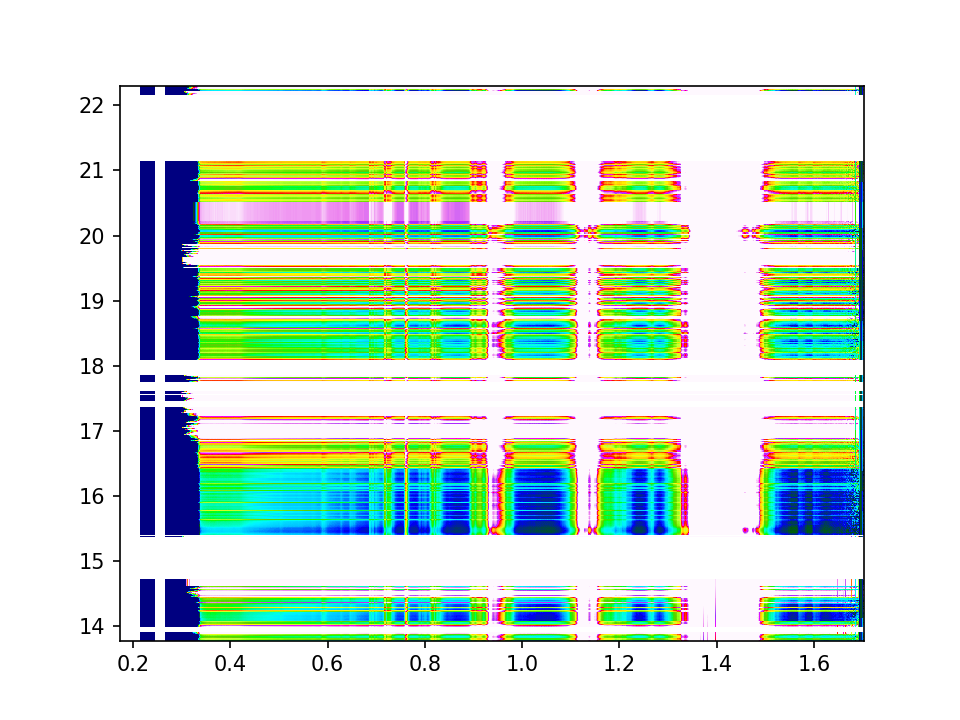

In [423]:
plt.figure()
plt.pcolor(s['w'],s['utc'],s['tau_aero'][:-1],cmap='gist_ncar',vmin=0,vmax=0.8)

### use the polyfit aod on the wavelength array

In [214]:
s['tau_aero_polynomial'].shape

(19716, 3)

In [215]:
wvl = np.array([0.25,0.35,0.4,0.5,0.675,0.87,0.995,1.2,1.4,1.6,2.1,3.2,4.9])

In [47]:
s['aod'] = np.zeros((len(s['utc']),len(wvl)))
for i in xrange(len(s['utc'])):
    s['aod'][i,:] = np.exp(np.polyval([s['tau_aero_polynomial'][i,0],s['tau_aero_polynomial'][i,1],
                                       s['tau_aero_polynomial'][i,2]],
                                         np.log(wvl)))


In [403]:
s['aod'].shape

KeyError: 'aod'

In [49]:
s['aod'][10:-1:200,:].shape

(99, 13)

(0.25, 5)

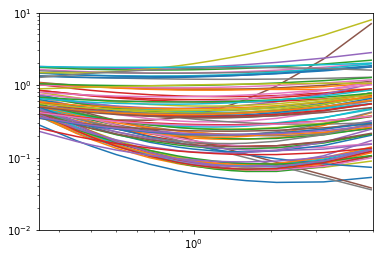

In [55]:
plt.figure()
plt.plot(wvl,s['aod'][10:-1:200,:].T)
plt.ylim(0,1)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.01,10)
plt.xlim(0.25,5)

### Alternative build of tau aero polynomials for AOD

In [216]:
wvl = np.array([0.25,0.35,0.4,0.5,0.675,0.87,0.995,1.2,1.4,1.6,2.1,3.2,4.9])

In [217]:
sai = s['aerosolcols'][0,:].astype(int)

<IPython.core.display.Javascript object>


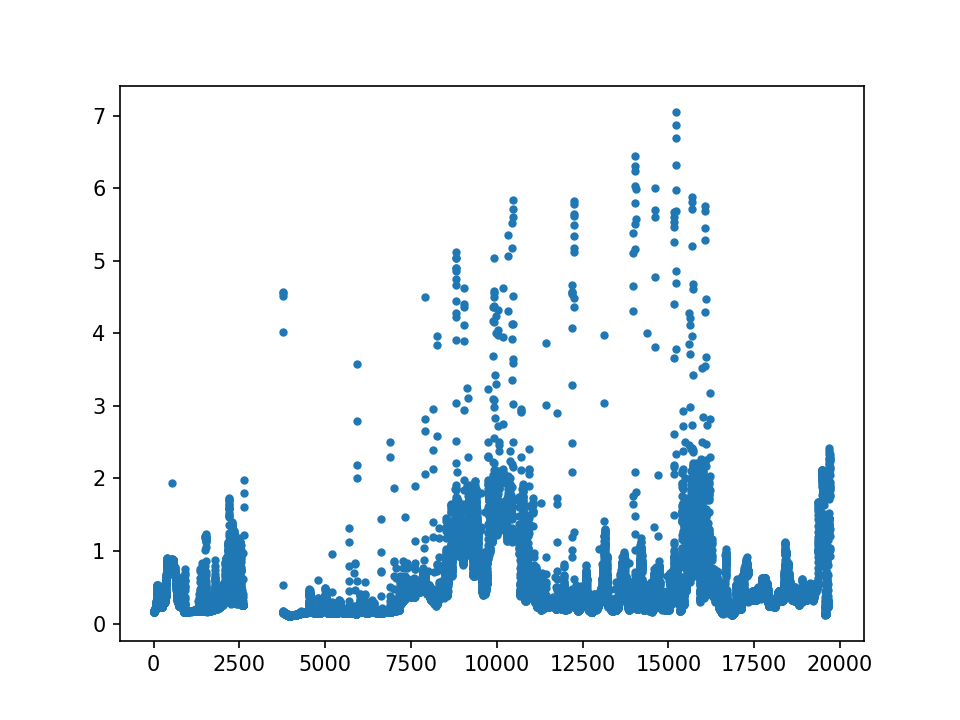

In [218]:
plt.figure()
plt.plot(s['tau_aero'][:,400],'.')

In [580]:
i=13884

In [220]:
s['tau_aero'].shape

(19716, 1556)

In [221]:
s['w'].shape

(1, 1556)

<IPython.core.display.Javascript object>


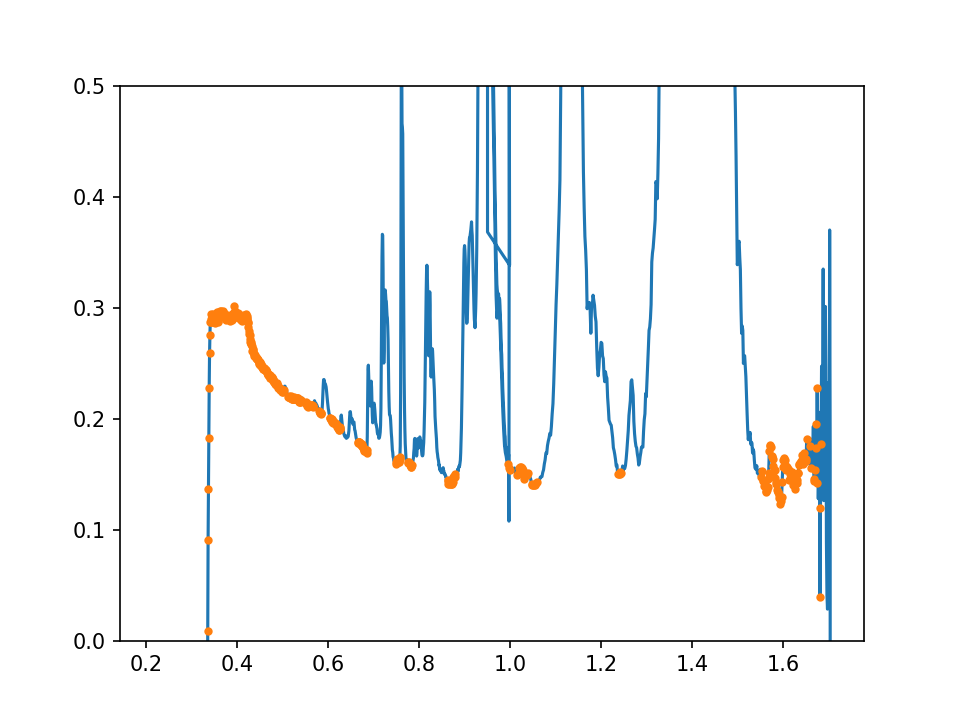

(0, 0.5)

In [222]:
plt.figure()
plt.plot(s['w'][0,:],s['tau_aero'][i,:],'-')
plt.plot(s['w'][0,sai],s['tau_aero'][i,sai],'.')
#plt.plot(wvl,s['aod'][i,:],'x-')
plt.ylim(0,0.5)


In [737]:
np.where(flag)[0]

array([    5,     6,     7, ..., 19580, 19581, 19582])

In [738]:
5%10

5

<IPython.core.display.Javascript object>


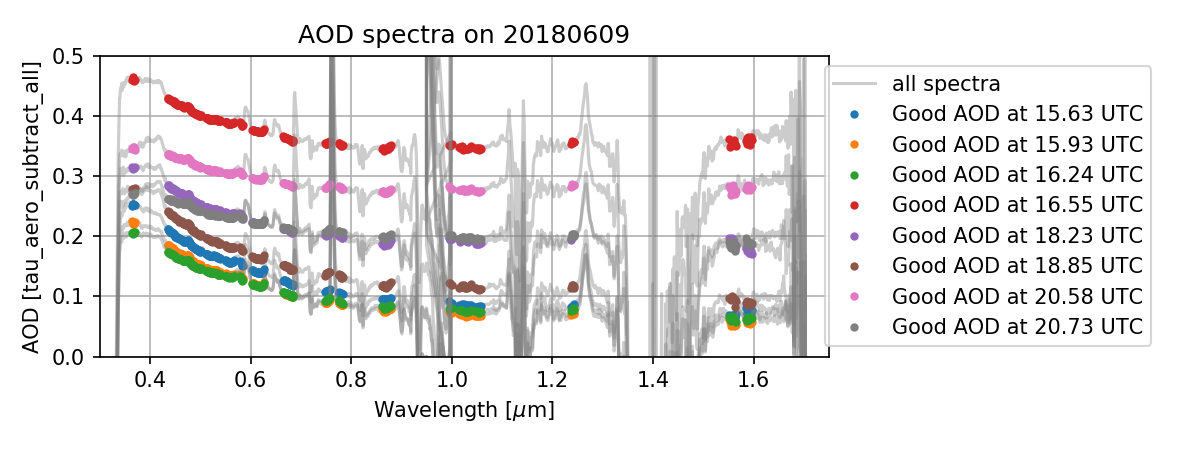

In [788]:
plt.figure(figsize=(8,3))
jfirst=True
for i in np.where(flag)[0]:
    if i%500 ==0:
        if jfirst:
            plt.plot(s['w'][0,:],s['tau_aero_subtract_all'][i,:],'-',color='grey',alpha=0.4,label='all spectra')
            jfirst=False
        else:
            plt.plot(s['w'][0,:],s['tau_aero_subtract_all'][i,:],'-',color='grey',alpha=0.4)
        plt.plot(s['w'][0,saii],s['tau_aero_subtract_all'][i,saii],'.',label='Good AOD at {:2.2f} UTC'.format(s['utc'][i]))
#plt.plot(wvl,s['aod'][i,:],'x-')
plt.ylim(0,0.5)
plt.xlim(0.3,1.75)
plt.grid()
plt.legend(bbox_to_anchor=(0.98, 1), loc='upper left', ncol=1)

plt.xlabel('Wavelength [$\mu$m]')
plt.ylabel('AOD [tau_aero_subtract_all]')
plt.title('AOD spectra on {}'.format(day))
plt.tight_layout()
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.96, box.height])
plt.savefig(fp+'plots/Good_AOD_spectra_examples_{}.png'.format(day),dpi=600,transparent=True)

In [777]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

<IPython.core.display.Javascript object>


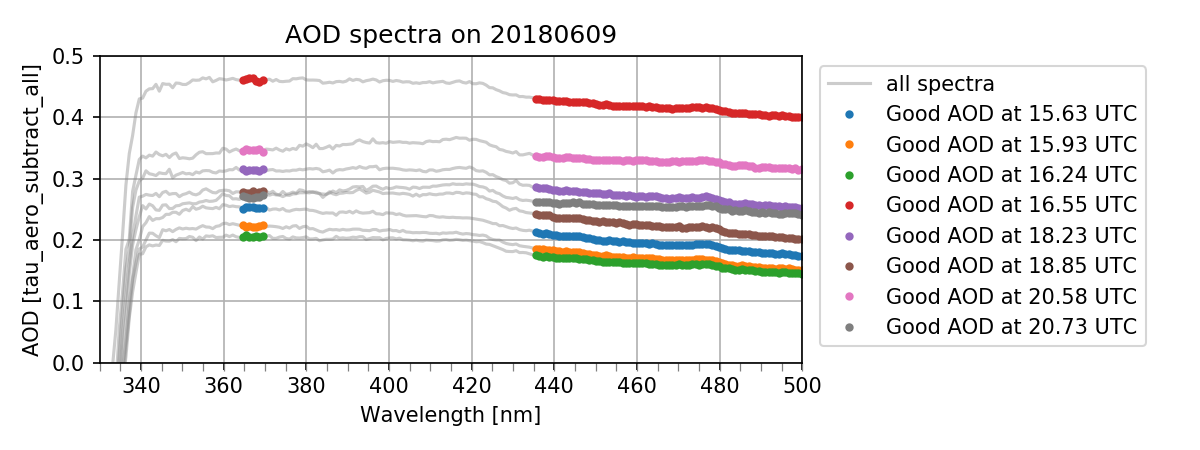

In [787]:
plt.figure(figsize=(8,3))
jfirst=True
for i in np.where(flag)[0]:
    if i%500 ==0:
        if jfirst:
            plt.plot(s['w'][0,:]*1000.0,s['tau_aero_subtract_all'][i,:],'-',color='grey',alpha=0.4,label='all spectra')
            jfirst=False
        else:
            plt.plot(s['w'][0,:]*1000.0,s['tau_aero_subtract_all'][i,:],'-',color='grey',alpha=0.4)
        plt.plot(s['w'][0,saii]*1000.0,s['tau_aero_subtract_all'][i,saii],'.',label='Good AOD at {:2.2f} UTC'.format(s['utc'][i]))
#plt.plot(wvl,s['aod'][i,:],'x-')
plt.ylim(0,0.5)
plt.xlim(330,500)
plt.grid(which='major')

plt.gca().xaxis.set_minor_locator(MultipleLocator(5))
plt.gca().tick_params(which='minor', length=4, color='grey')

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)

plt.xlabel('Wavelength [nm]')
plt.ylabel('AOD [tau_aero_subtract_all]')
plt.title('AOD spectra on {}'.format(day))
plt.tight_layout()
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.96, box.height])
plt.savefig(fp+'plots/Good_AOD_spectra_examples_zoomed_{}.png'.format(day),dpi=600,transparent=True)

In [752]:
s['w'][0,saii]

array([0.364636 , 0.365444 , 0.366251 , 0.367059 , 0.367866 , 0.368674 ,
       0.369481 , 0.435602 , 0.436407 , 0.437212 , 0.438017 , 0.438821 ,
       0.439626 , 0.440431 , 0.441236 , 0.442041 , 0.442845 , 0.44365  ,
       0.444455 , 0.445259 , 0.446064 , 0.446868 , 0.447673 , 0.448477 ,
       0.449282 , 0.450086 , 0.450891 , 0.451695 , 0.452499 , 0.453303 ,
       0.454108 , 0.454912 , 0.455716 , 0.45652  , 0.457324 , 0.458128 ,
       0.458932 , 0.459736 , 0.46054  , 0.461344 , 0.462147 , 0.462951 ,
       0.463755 , 0.464559 , 0.465362 , 0.466166 , 0.466969 , 0.467773 ,
       0.468576 , 0.46938  , 0.470183 , 0.470987 , 0.47179  , 0.472593 ,
       0.473396 , 0.4742   , 0.475003 , 0.475806 , 0.476609 , 0.477412 ,
       0.478215 , 0.479018 , 0.479821 , 0.480624 , 0.481427 , 0.482229 ,
       0.483032 , 0.483835 , 0.484638 , 0.48544  , 0.486243 , 0.487045 ,
       0.487848 , 0.48865  , 0.489453 , 0.490255 , 0.491057 , 0.49186  ,
       0.492662 , 0.493464 , 0.494266 , 0.495068 , 

<IPython.core.display.Javascript object>


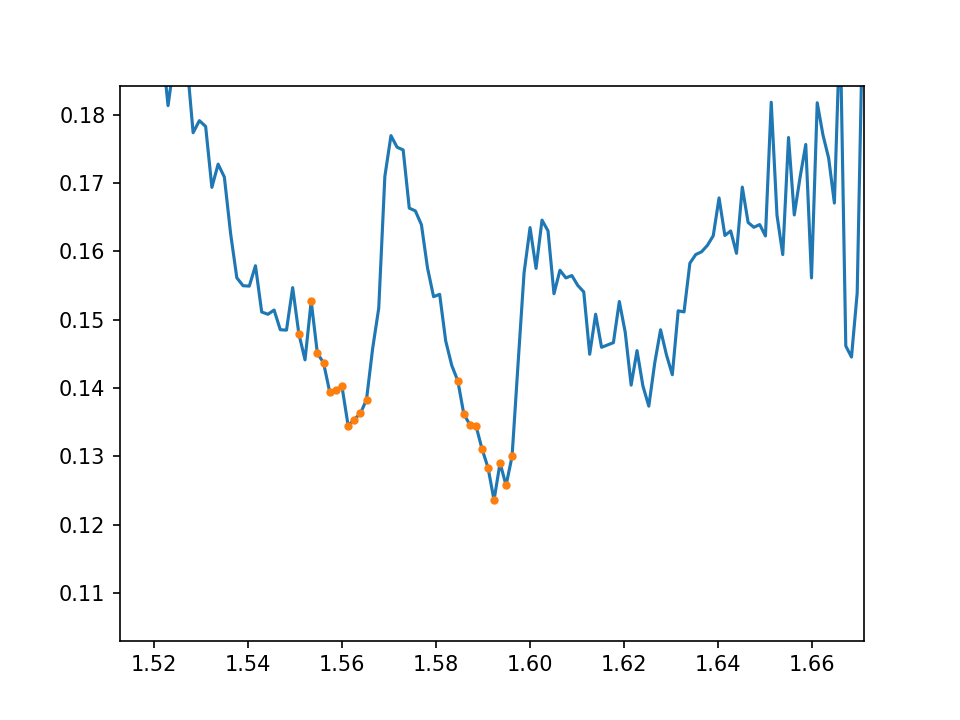

(0, 0.5)

In [583]:
plt.figure()
plt.plot(s['w'][0,:],s['tau_aero'][i,:],'-')
plt.plot(s['w'][0,saii],s['tau_aero'][i,saii],'.')
plt.ylim(0,0.5)

In [582]:
saii = sai[((s['w'][0,sai]>0.364) & (s['w'][0,sai]<0.370)) | ((s['w'][0,sai]>0.435) & (s['w'][0,sai]<1.566)) | 
            ((s['w'][0,sai]>1.584) & (s['w'][0,sai]<1.597)) ]

In [224]:
pl = su.logaod_polyfit(np.append(s['w'][0,saii],[2.2,2.7,3.5]),np.append(s['tau_aero'][i,saii],[s['tau_aero'][i,saii][-1]*2.0/3.0,s['tau_aero'][i,saii][-1]/2.0,s['tau_aero'][i,saii][-1]/4.0]),polynum=2)

<IPython.core.display.Javascript object>


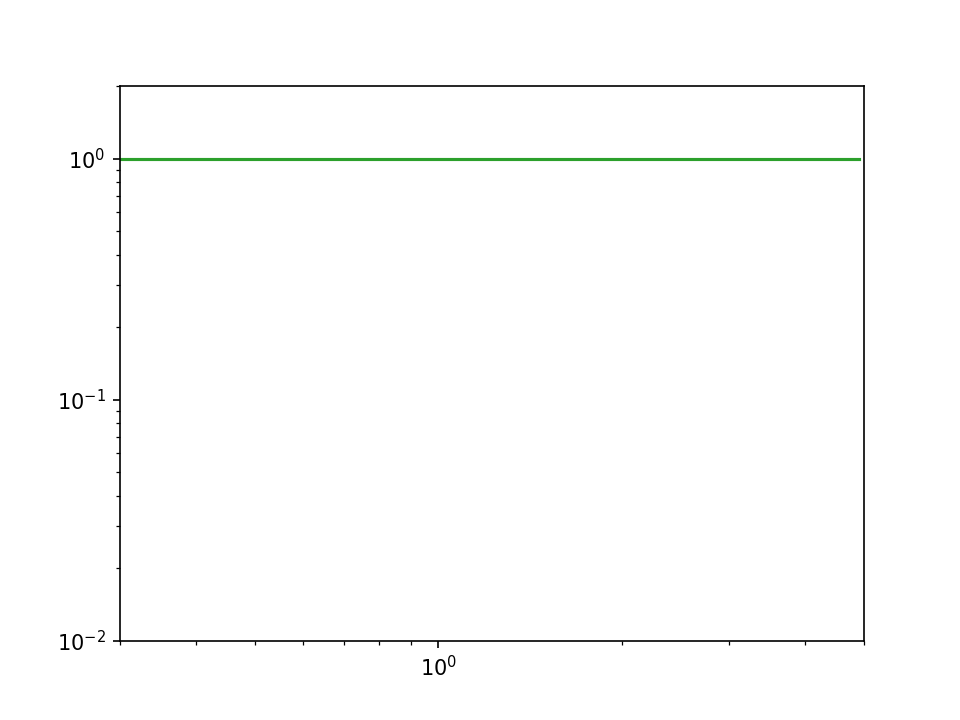

/home/sam/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


(0.3, 5)

In [553]:
plt.figure()
plt.plot(s['w'][0,:],s['tau_aero'][i,:],'-')
plt.plot(s['w'][0,sai],s['tau_aero'][i,sai],'.')
#plt.plot(wvl,s['aod'][i,:],'x-')
plt.plot(wvl,np.exp(np.polyval(pl,np.log(wvl))))

plt.yscale('log')
plt.xscale('log')
plt.ylim(0.01,2)
plt.xlim(0.3,5)


In [226]:
from scipy import polyfit

In [760]:
tau_aero_good = np.array([np.append(s['tau_aero_subtract_all'][i,saii],[s['tau_aero_subtract_all'][i,saii][-1]*2.0/3.0,
                                                           s['tau_aero_subtract_all'][i,saii][-1]/2.0,s['tau_aero_subtract_all'][i,saii][-1]/10.0]) \
                          for i in xrange(len(s['t']))])

In [761]:
poly = np.array([polyfit(np.log(np.append(s['w'][0,saii],[2.2,2.7,3.7])),np.log(aodd),2) for aodd in tau_aero_good])

In [229]:
poly.shape

(19716, 3)

In [762]:
s['paod'] = np.zeros((len(s['utc']),len(wvl)))
for i in xrange(len(s['utc'])):
    s['paod'][i,:] = np.exp(np.polyval(poly[i,:],np.log(wvl)))


<IPython.core.display.Javascript object>


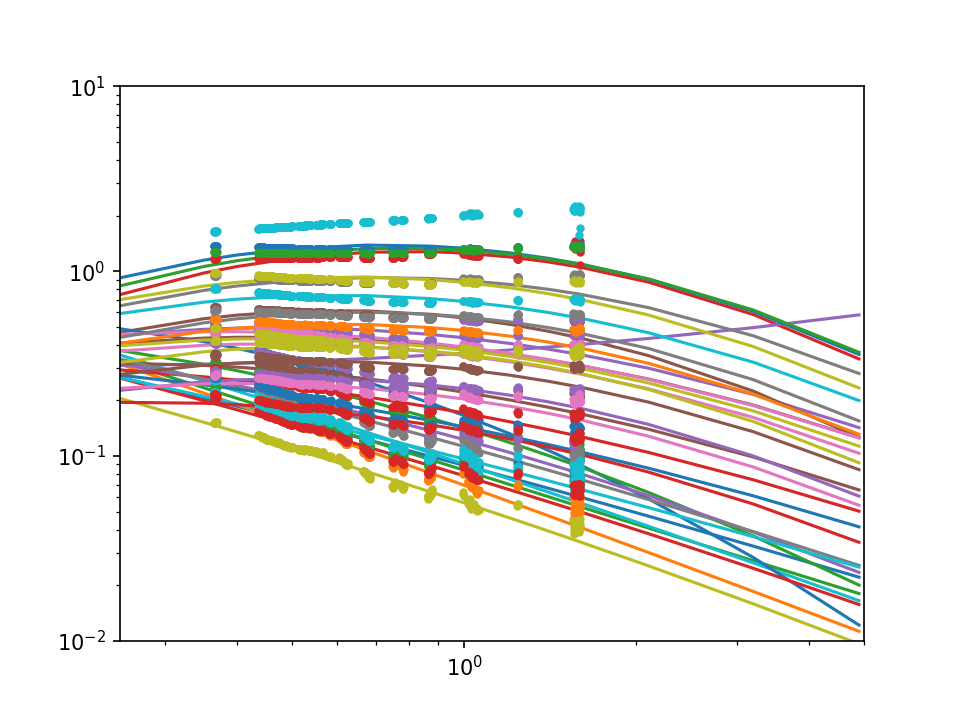

(0.25, 5)

In [763]:
plt.figure()
plt.plot(wvl,s['paod'][10:-1:500,:].T)
plt.plot(s['w'][0,saii],s['tau_aero'][10:-1:500,saii].T,'.')
plt.ylim(0,1)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.01,10)
plt.xlim(0.25,5)

In [232]:
s['aod'] = s['paod']

### Load the flag files

In [233]:
fmat = getpath('4STAR_data')

Return path named:  4STAR_data /home/sam/4STAR_codes/data_folder/


In [234]:
with open (fmat+'starinfo_{}.m'.format(day), 'rt') as in_file:
    for line in in_file:
        if 'flagfilename ' in line:
            ff = line.split("'")[1]
sf = hs.loadmat(fmat+ff)

In [235]:
sf.keys()

[u'unspecified_clouds',
 u'manual_flags',
 u'bad_aod',
 u'flagfile',
 u'screen',
 u'frost',
 u'before_or_after_flight',
 u'unspecified_aerosol',
 u'hor_legs',
 u'flags',
 u'low_cloud',
 u'smoke',
 u'time',
 u'dust',
 u'vert_legs',
 u'screened',
 u'cirrus']

In [236]:
flag = sf['manual_flags']['good'][0,:,0]

In [237]:
flag.shape

(19716,)

In [238]:
sum(flag)

6582

## Load the solar spectrum

In [615]:
fp_librad

u'/home/sam/libradtran/libRadtran-2.0.2b/data/'

In [616]:
sol = np.genfromtxt(fp_librad+'solar_flux/kurudz_1.0nm.dat')

In [617]:
sol.shape

(9751, 2)

<IPython.core.display.Javascript object>


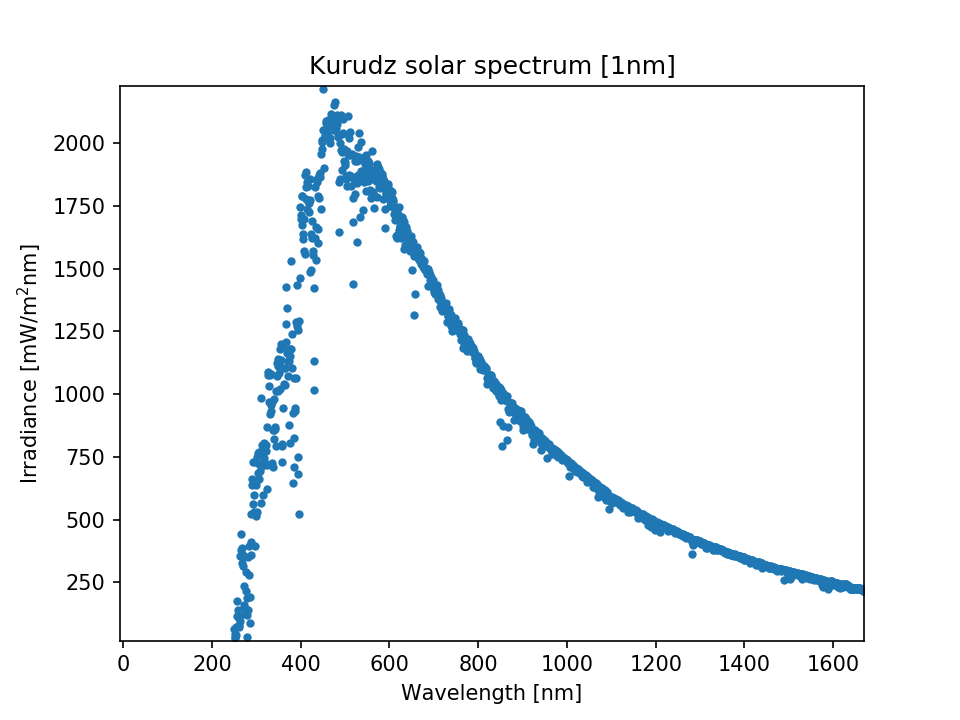

Text(0.5,0,'Wavelength [nm]')

In [619]:
plt.figure()
plt.plot(sol[:,0],sol[:,1],'.')
plt.ylabel('Irradiance [mW/m$^2$nm]')
plt.title('Kurudz solar spectrum [1nm]')
plt.xlabel('Wavelength [nm]')

In [620]:
sol[:,1].sum()

1365801.1692718002

<IPython.core.display.Javascript object>


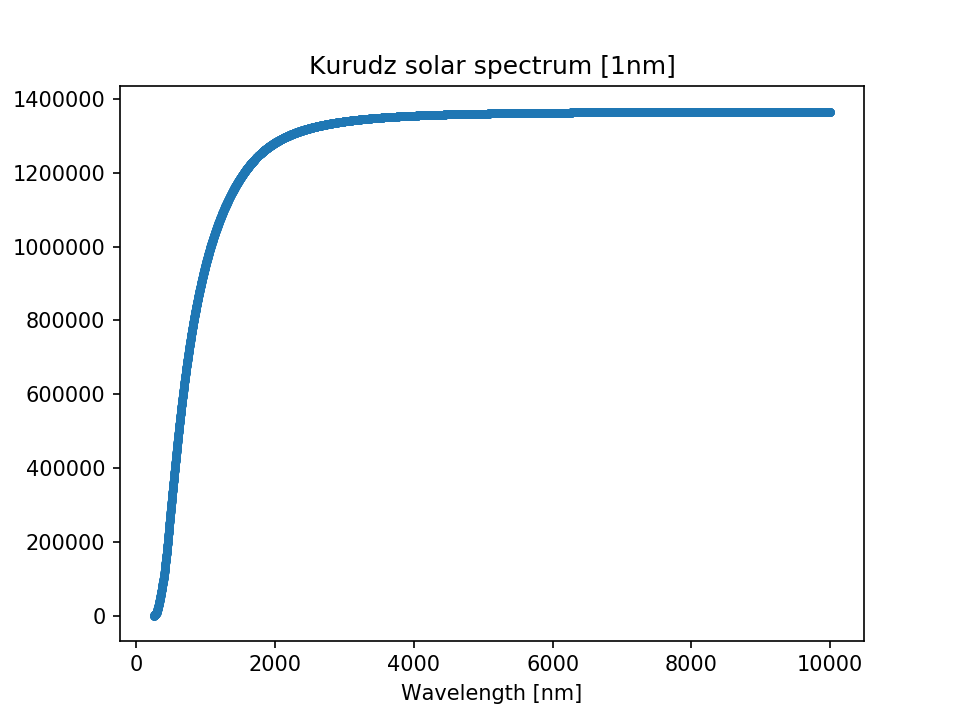

Text(0.5,0,'Wavelength [nm]')

In [623]:
plt.figure()
plt.plot(sol[:,0],sol[:,1].cumsum(),'.')
plt.ylabel('Cumulative Irradiance [mW/m$^2$nm]')
plt.title('Kurudz solar spectrum [1nm]')
plt.xlabel('Wavelength [nm]')

<IPython.core.display.Javascript object>


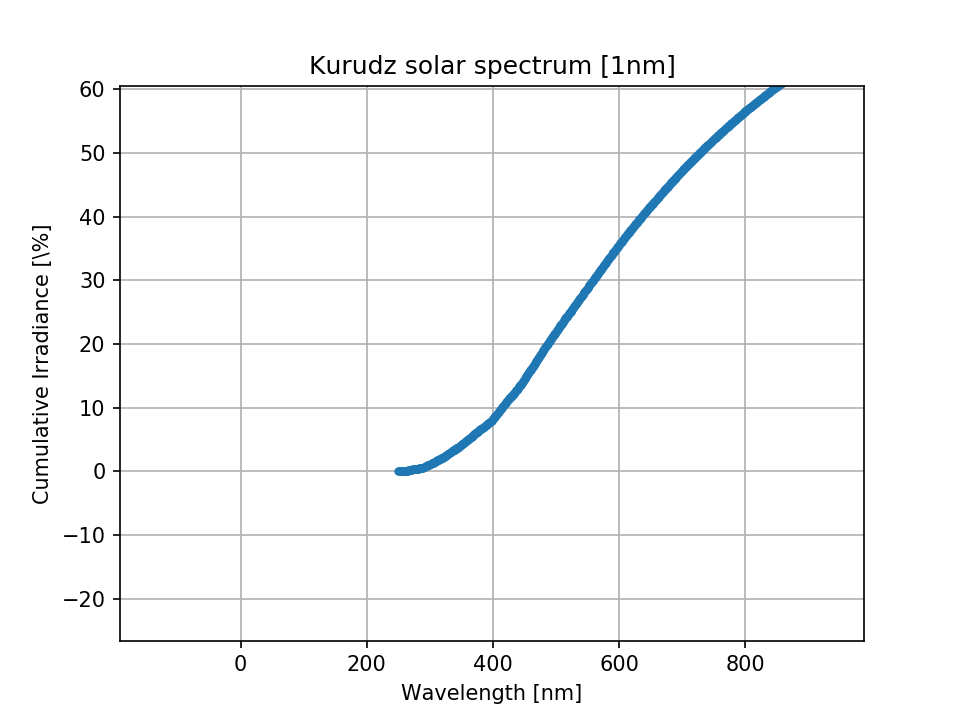

In [624]:
plt.figure()
plt.plot(sol[:,0],sol[:,1].cumsum()/sol[:,1].sum()*100.0,'.')
plt.ylabel('Cumulative Irradiance [\%]')
plt.title('Kurudz solar spectrum [1nm]')
plt.xlabel('Wavelength [nm]')
plt.grid()

## Load the skyscan results

In [239]:
sk_names = {
    '20180624':'4STAR_20180624_135_SKYP.created_20190329_003621.ppl_lv15.mat',
    '20180625':'4STAR_20180625_026_SKYP.created_20190507_213718.ppl_lv15.mat',
    '20180620':'4STAR_20180620_017_SKYP.created_20190507_225712.ppl_lv15.mat',
    '20180618':'4STAR_20180618_029_SKYA.created_20190507_232752.avg_lv10.mat',
    '20180609':'4STAR_20180609_041_SKYP.created_20190508_003116.ppl_lv15.mat',
    '20180705':'4STAR_20180705_061_SKYP.created_20190508_003930.ppl_lv15.mat'}

In [240]:
sk_n = {
    '20180624':'135',
    '20180625':'026',
    '20180620':'017',
    '20180618':'029',
    '20180609':'041',
    '20180705':'061'}

In [241]:
fp_name = sk_names[day]#'4STAR_20180624_135_SKYP.created_20190329_003621.ppl_lv15.mat'

In [242]:
sky = sio.loadmat(fp+fp_name)
sky.keys()

['sky_radiances_pct_diff',
 'ext_fine',
 'flux_dn',
 'Sphericity_err',
 'Sphericity',
 'sky_radiances_angle',
 'sky_radiances_measured',
 'ssa_total',
 'radius',
 'flux_diffuse',
 'sfc_alb',
 'input_fname',
 'ssa_coarse',
 'sky_bias',
 'aaod',
 'fstem',
 'tod_fit',
 'output_fname',
 'g_coarse',
 'tod_meas',
 'input',
 'PF_coarse',
 'PF_total',
 'PF_fine',
 'aod',
 'g_fine',
 'refractive_index_real_r',
 'refractive_index_imaginary_r',
 'tod_meas_less_fit',
 'g_tot',
 'psd',
 'Wavelength',
 'PF_angle',
 '__version__',
 'ext_coarse',
 'ext_total',
 '__header__',
 '__globals__',
 'flux_up',
 'ssa_fine',
 'sky_radiances_fit',
 'sky_error']

In [447]:
sky['refractive_index_real_r']

array([[1.6],
       [1.6],
       [1.6],
       [1.6],
       [1.6]])

In [448]:
sky['refractive_index_imaginary_r']

array([[0.0032619],
       [0.0032489],
       [0.0032098],
       [0.0031842],
       [0.003181 ]])

# Plot out some data

## Plot out the retrieved skyscans

<IPython.core.display.Javascript object>


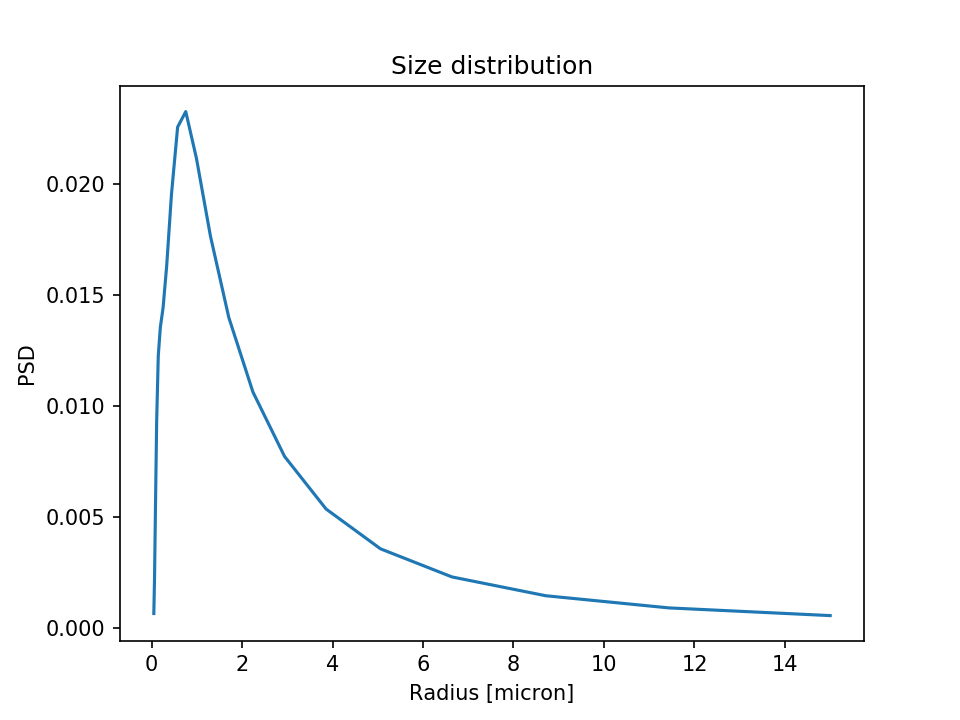

Text(0,0.5,'PSD')

In [451]:
plt.figure()
plt.plot(sky['radius'],sky['psd'])
plt.title('Size distribution')
plt.xlabel('Radius [micron]')
plt.ylabel('PSD')

<IPython.core.display.Javascript object>


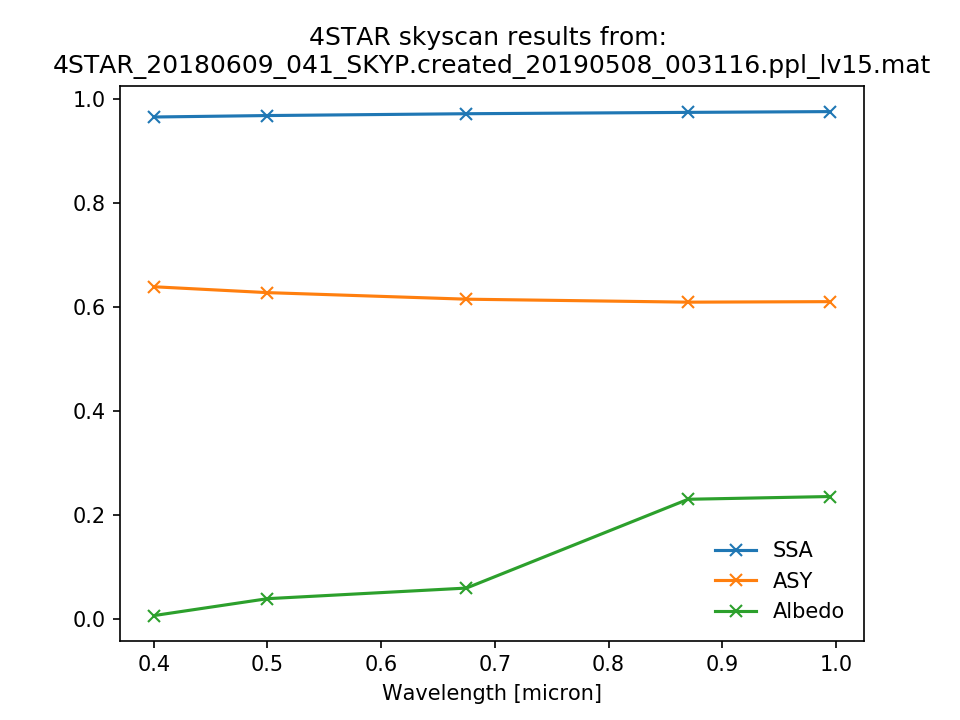

In [440]:
plt.figure()
plt.plot(sky['Wavelength'],sky['ssa_total'][0,:],'x-',label='SSA')
plt.plot(sky['Wavelength'],sky['g_tot'][0,:],'x-',label='ASY')
plt.plot(sky['Wavelength'],sky['sfc_alb'][0,:],'x-',label='Albedo')


plt.legend(frameon=False)
plt.xlabel('Wavelength [micron]')
plt.title('4STAR skyscan results from: \n' + fp_name)
plt.savefig(fp+'plots/4STAR_skyscan_result_{}_{}_{}_SKYP.png'.format(day,sk_n[day],vv),dpi=600,transparent=True)

In [244]:
sky['g_tot'][-1]

array([0.6382614 , 0.62695787, 0.6143521 , 0.60862112, 0.60960551])

## Expand the sky scans results to longer wavelengths

In [551]:
#wvl = np.array([0.35,0.4,0.5,0.675,0.87,0.995,1.2,1.4,1.6,2.1,4.0])
f_asy = interp1d(np.append(sky['Wavelength'][:,0],[2.0,2.6]),np.append(sky['g_tot'][0,:],[sky['g_tot'][0,-1]+0.008,sky['g_tot'][0,-1]-0.058]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
asy = f_asy(wvl)
f_ssa = interp1d(np.append(sky['Wavelength'][:,0],[1.5,2.0,2.3]),np.append(sky['ssa_total'][0,:],[sky['ssa_total'][0,-1]+0.003,sky['ssa_total'][0,-1]+0.0015,sky['ssa_total'][0,-1]-0.002]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
ssa = f_ssa(wvl)
f_alb = interp1d(np.append(np.append([0.25,0.35],sky['Wavelength'][:,0]),[1.65,2.2,3.0,5.0]),
                 np.append(np.append([0.01,0.01],sky['sfc_alb'][0,:]),[sky['sfc_alb'][0,-1]*0.5,sky['sfc_alb'][0,-1]*0.25,0.04,0.02]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
alb = f_alb(wvl)

In [70]:
# for 20180624 only
if day=='20180624':
    f_asy = interp1d(np.append(sky['Wavelength'][:,0],[1.1,2.4]),np.append(sky['g_tot'][0,:],[sky['g_tot'][0,-1]-0.01,sky['g_tot'][0,-1]-0.13]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
    asy = f_asy(wvl)
    f_ssa = interp1d(np.append(sky['Wavelength'][:,0],[1.1,1.2,1.3]),np.append(sky['ssa_total'][0,:],[sky['ssa_total'][0,-1]-0.012,sky['ssa_total'][0,-1]-0.022,sky['ssa_total'][0,-1]-0.034]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
    ssa = f_ssa(wvl)

In [162]:
if day=='20180625':
    f_asy = interp1d(np.append(sky['Wavelength'][:,0],[1.1,2.4]),np.append(sky['g_tot'][0,:],[sky['g_tot'][0,-1]-0.005,sky['g_tot'][0,-1]-0.008]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
    asy = f_asy(wvl)
    f_ssa = interp1d(np.append(sky['Wavelength'][:,0],[1.1,1.2,1.3]),np.append(sky['ssa_total'][0,:],[sky['ssa_total'][0,-1]-0.012,sky['ssa_total'][0,-1]-0.022,sky['ssa_total'][0,-1]-0.034]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
    ssa = f_ssa(wvl)

In [286]:
if day=='20180609':
    f_asy = interp1d(np.append(sky['Wavelength'][:,0],[1.1,2.4]),np.append(sky['g_tot'][0,:],[sky['g_tot'][0,-1]-0.002,sky['g_tot'][0,-1]-0.005]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
    asy = f_asy(wvl)
    f_ssa = interp1d(np.append(sky['Wavelength'][:,0],[1.1,1.2,1.3]),np.append(sky['ssa_total'][0,:],[sky['ssa_total'][0,-1]-0.008,sky['ssa_total'][0,-1]-0.016,sky['ssa_total'][0,-1]-0.020]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
    ssa = f_ssa(wvl)

In [287]:
np.append(sky['ssa_total'][0,:],[sky['ssa_total'][0,-1]-0.008,sky['ssa_total'][0,-1]-0.002])

array([0.9648, 0.9676, 0.9711, 0.9737, 0.9752, 0.9672, 0.9732])

In [431]:
sky['Wavelength'][:,0]

array([0.4  , 0.5  , 0.675, 0.87 , 0.995])

In [430]:
sky['sfc_alb'][0,:]

array([0.005669, 0.038229, 0.058627, 0.229436, 0.234727])

<IPython.core.display.Javascript object>


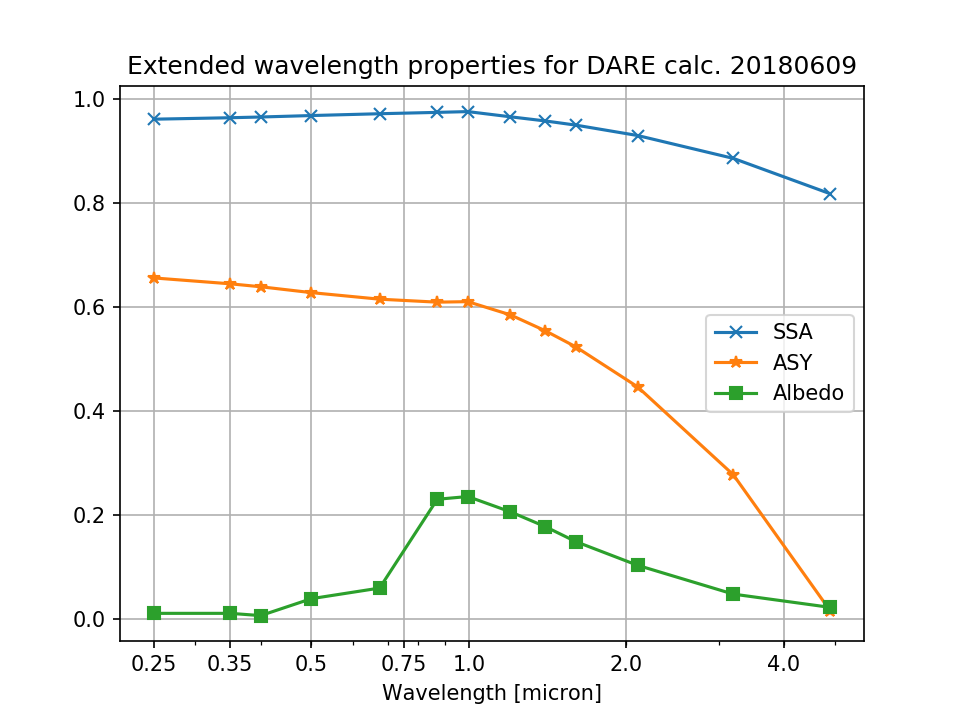

In [442]:
plt.figure()
plt.plot(wvl,ssa,'-x',label='SSA')
plt.plot(wvl,asy,'-*',label='ASY')
plt.plot(wvl,alb,'-s',label='Albedo')
plt.xscale('log')
plt.xticks([0.25,0.35,0.5,0.75,1.0,2.0,4.0],[0.25,0.35,0.5,0.75,1.0,2.0,4.0])
plt.grid()
plt.legend()
plt.xlabel('Wavelength [micron]')
plt.title('Extended wavelength properties for DARE calc. {}'.format(day))
plt.savefig(fp+'plots/AERO_prop_for_DARE_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


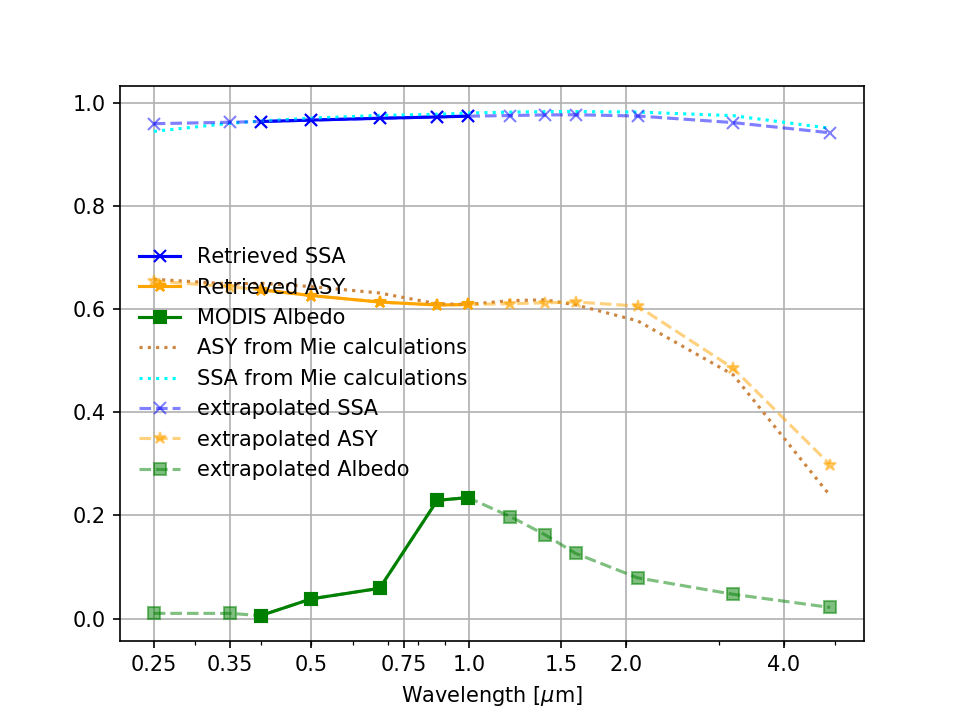

In [529]:
plt.figure()

plt.plot(sky['Wavelength'],sky['ssa_total'][0,:],'x-',color='b',label='Retrieved SSA')
plt.plot(sky['Wavelength'],sky['g_tot'][0,:],'*-',color='orange',label='Retrieved ASY')
plt.plot(sky['Wavelength'],sky['sfc_alb'][0,:],'s-',color='g',label='MODIS Albedo')

plt.plot(mout['wvl']/1000.0,mout['asy'],':',color='peru',label='ASY from Mie calculations')
plt.plot(mout['wvl']/1000.0,mout['ssa'],':',color='aqua',label='SSA from Mie calculations')

plt.plot(wvl,ssa,'--x',label='extrapolated SSA',color='b',alpha=0.5)
plt.plot(wvl,asy,'--*',label='extrapolated ASY',color='orange',alpha=0.5)
plt.plot(wvl,alb,'--s',label='extrapolated Albedo',color='g',alpha=0.5)
plt.xscale('log')
plt.xticks([0.25,0.35,0.5,0.75,1.0,1.5,2.0,4.0],[0.25,0.35,0.5,0.75,1.0,1.5,2.0,4.0])
plt.grid()
plt.legend(frameon=False,loc=6)
plt.xlabel('Wavelength [$\\mu$m]')
#plt.title('Extended wavelength properties for DARE calc. {}'.format(day))
plt.savefig(fp+'plots/AERO_prop_extrapolated_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

### Load the spectral albedo for grass

In [508]:
albg_wvl = np.genfromtxt(fp+'data_other/splib07a_Wavelengths_BECK_Beckman_0.2-3.0_microns.txt',skip_header=1)
albg_alb = np.genfromtxt(fp+'data_other/splib07a_Lawn_Grass_GDS91_green_BECKa_AREF.txt',skip_header=1)

In [513]:
albg_alb[albg_alb<0] = 0.0

<IPython.core.display.Javascript object>


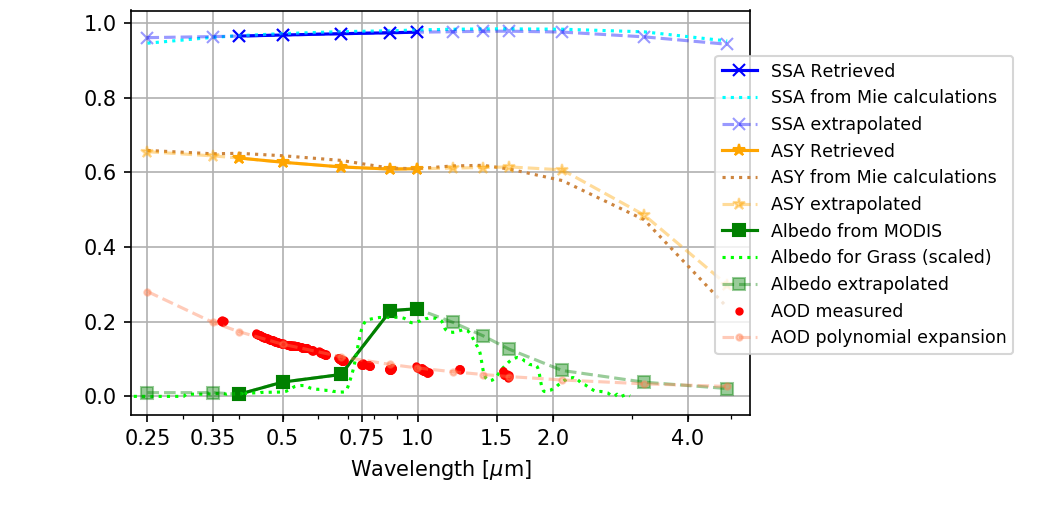

In [625]:
plt.figure(figsize=(7,3.5))

plt.plot(sky['Wavelength'],sky['ssa_total'][0,:],'x-',color='b',label='SSA Retrieved')
plt.plot(mout['wvl']/1000.0,mout['ssa'],':',color='aqua',label='SSA from Mie calculations')
plt.plot(wvl,ssa,'--x',label='SSA extrapolated',color='b',alpha=0.4)

plt.plot(sky['Wavelength'],sky['g_tot'][0,:],'*-',color='orange',label='ASY Retrieved')
plt.plot(mout['wvl']/1000.0,mout['asy'],':',color='peru',label='ASY from Mie calculations')
plt.plot(wvl,asy,'--*',label='ASY extrapolated',color='orange',alpha=0.4)

plt.plot(sky['Wavelength'],sky['sfc_alb'][0,:],'s-',color='g',label='Albedo from MODIS') #  [MCD43GF; Schaaf et al., ]
plt.plot(albg_wvl,albg_alb*0.3,':',color='lime',label='Albedo for Grass (scaled)') #[Kokaly et al., 2017]
plt.plot(wvl,alb,'--s',label='Albedo extrapolated',color='g',alpha=0.4)

i = 1201
plt.plot(s['w'][0,saii],s['tau_aero'][flag,:][i,saii],'.',color='red',label='AOD measured')
plt.plot(wvl,s['paod'][flag,:].T[:,i],'--.',color='coral',alpha=0.4,label='AOD polynomial expansion')

plt.xscale('log')
plt.xticks([0.25,0.35,0.5,0.75,1.0,1.5,2.0,4.0],[0.25,0.35,0.5,0.75,1.0,1.5,2.0,4.0])
plt.xlim(0.23,5.5)
plt.grid()

plt.xlabel('Wavelength [$\\mu$m]')
#plt.title('Extended wavelength properties for DARE calc. {}'.format(day))
plt.legend(frameon=True,bbox_to_anchor=(0.93,0.91),loc=2,fontsize='small')

box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0+0.1, box.width * 0.76, box.height])

plt.savefig(fp+'plots/AERO_prop_extrapolated_plusalb_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

## Get the vertical dependence of the extinction

In [288]:
f_alt = interp1d(x=s['utc'],y=s['Alt'][:,0])
insitu['alt'] = f_alt(insitu['utc'])

In [253]:
if day=='20180624':
    insitu['extCalc500nm'] = insitu['extCalc500nm']*10.0

In [258]:
if day=='20180609':
    insitu['extCalc500nm'] = insitu['extCalc500nm']*10.0

<IPython.core.display.Javascript object>


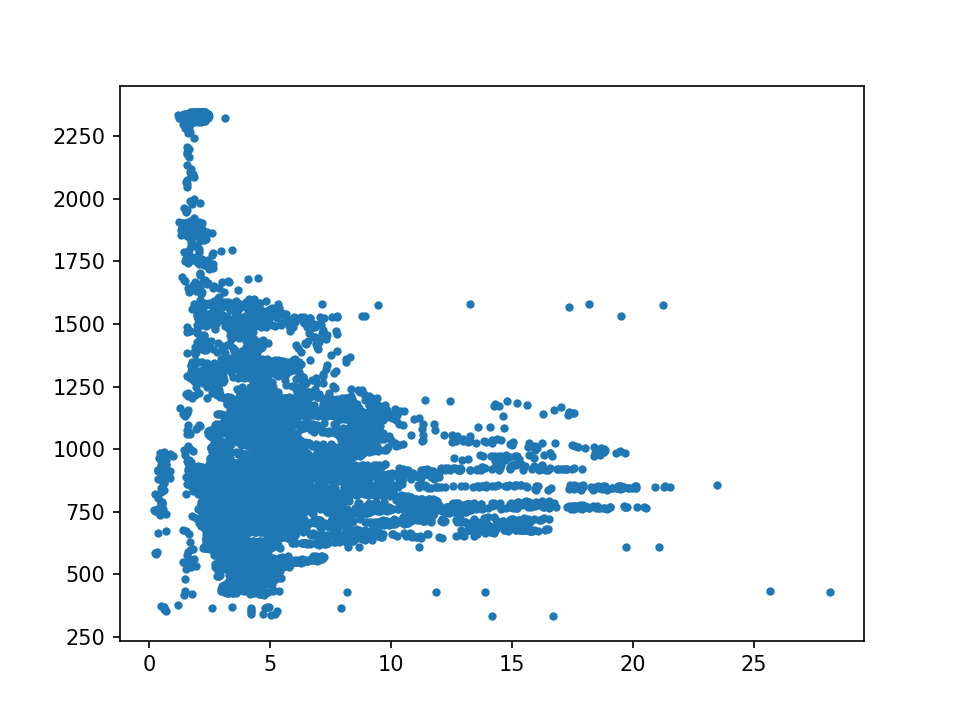

In [289]:
plt.figure()
plt.plot(insitu['extCalc500nm'],insitu['alt'],'.')

<IPython.core.display.Javascript object>


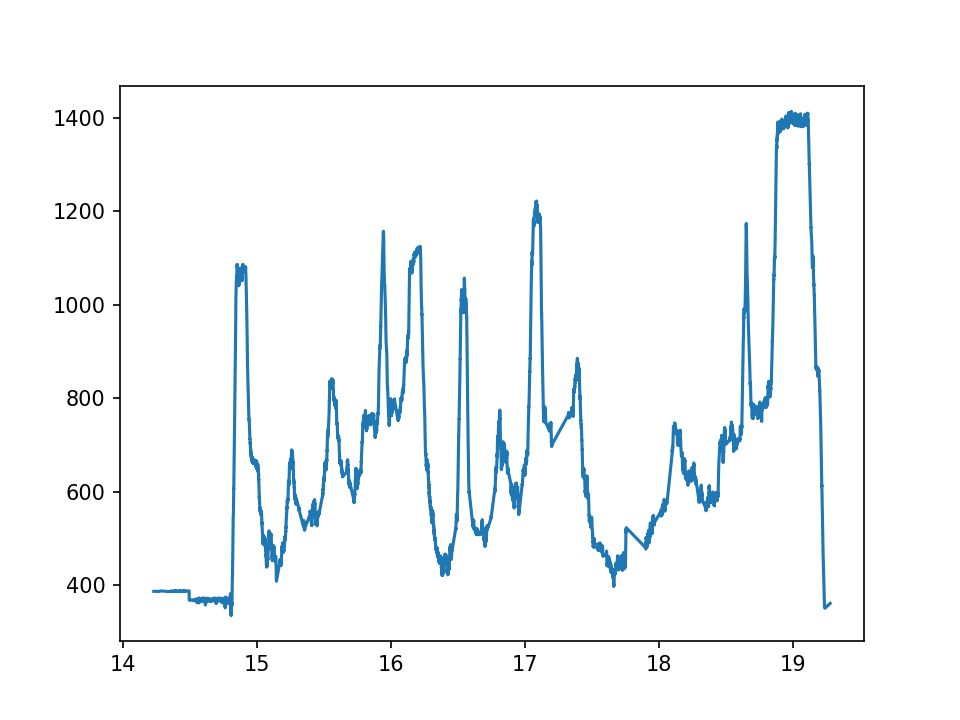

In [74]:
plt.figure()
plt.plot(insitu['utc'],insitu['alt'])

<IPython.core.display.Javascript object>


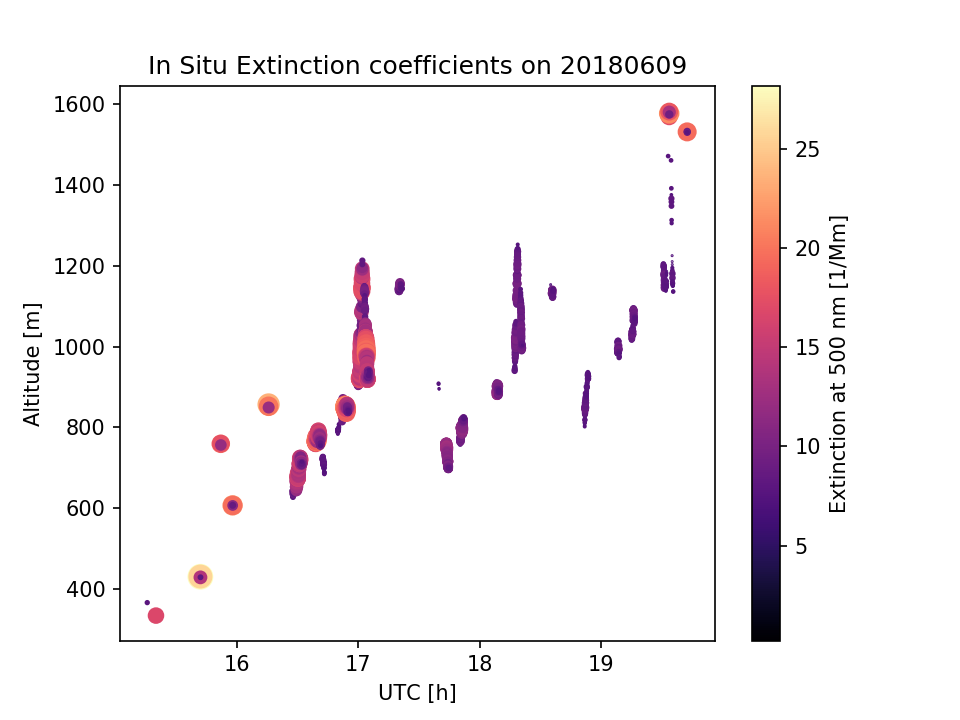

In [255]:
plt.figure()
plt.scatter(insitu['utc'],insitu['alt'],c=insitu['extCalc500nm'],cmap=plt.cm.magma,s=(insitu['extCalc500nm'])**1.5-20.0)
cb = plt.colorbar()
cb.set_label('Extinction at 500 nm [1/Mm]')
plt.xlabel('UTC [h]')
plt.ylabel('Altitude [m]')
plt.title('In Situ Extinction coefficients on {}'.format(day))
plt.savefig(fp+'plots/Extinction_UTC_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

In [75]:
np.isfinite(insitu['extCalc500nm'])

array([False, False, False, ..., False, False, False])

In [290]:
binned_ext,binned_alt,binned_num = [],[],[]
for i in xrange(17):
    flaa = (insitu['alt']>=i*100.0) & (insitu['alt']<(i+1.0)*100.0) & (np.isfinite(insitu['extCalc500nm']))
    if flaa.any():
        binned_ext.append(insitu['extCalc500nm'][flaa])
        binned_alt.append(np.mean([i*100.0,(i+1.0)*100.0]))
        binned_num.append(len(insitu['extCalc500nm'][flaa]))

<IPython.core.display.Javascript object>


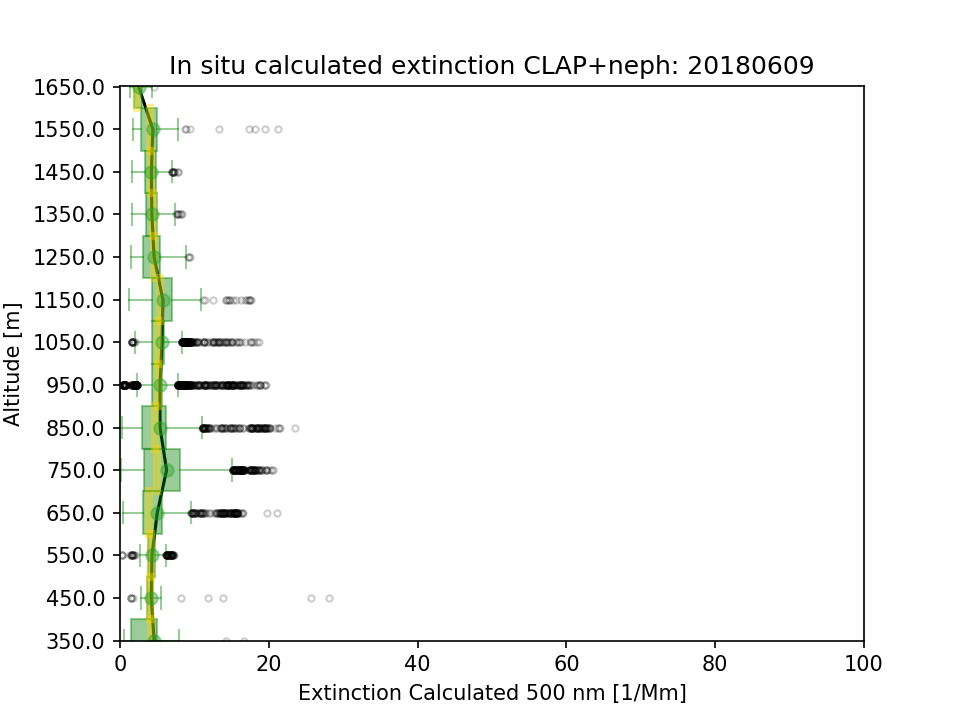

In [291]:
plt.figure()
bp =plt.boxplot(binned_ext,positions=binned_alt,vert=False,showfliers=True,widths=100,showmeans=True,patch_artist=True)
plt.xlabel('Extinction Calculated 500 nm [1/Mm]')
plt.ylabel('Altitude [m]')
#plt.plot(s['angs_470_865'][s['fl_QA_angs']],s['GPS_Alt'][s['fl_QA_angs']],'.',alpha=0.005)
for b in bp['boxes']:
    b.set_facecolor('green')
    b.set_edgecolor('green')
    b.set_alpha(0.4)
for b in bp['means']:
    b.set_marker('o')
    b.set_color('firebrick')
    b.set_alpha(0.4)
for b in bp['whiskers']:
    b.set_linestyle('-')
    b.set_color('green')
    b.set_alpha(0.4)
for b in bp['caps']:
    b.set_alpha(0.4)
    b.set_color('green')
for b in bp['medians']:
    b.set_linewidth(4)
    b.set_color('gold')
    b.set_alpha(0.4)
for b in bp['fliers']:
    b.set_marker('.')
    b.set_alpha(0.2)
ext_means = np.array([[b.get_data()[0][0],b.get_data()[1][0]] for b in bp['means']])
plt.plot(ext_means[:,0],ext_means[:,1],'-k')
plt.xlim(0,100)
plt.title('In situ calculated extinction CLAP+neph: {}'.format(day))
plt.savefig(fp+'plots/extinction_vertical_bins_clap_neph_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

In [292]:
ext_z = ext_means[:,1]/1000.0
ext_ = ext_means[:,0]/1000.0
aod_ = ext_.sum()/10.0

In [293]:
ext_z = np.append(ext_z,ext_z[-1]+0.1)

In [294]:
nz = len(ext_z)

In [295]:
ext_ = np.append(ext_,ext_[-1]*0.0)

In [296]:
ext_,aod_

(array([0.00458069, 0.0042096 , 0.00429402, 0.00500835, 0.00626286,
        0.00537621, 0.00537997, 0.00564844, 0.00576162, 0.00458441,
        0.00428117, 0.00421631, 0.00441747, 0.00249898, 0.        ]),
 0.006652010485409855)

In [717]:
ext_

array([0.00458069, 0.0042096 , 0.00429402, 0.00500835, 0.00626286,
       0.00537621, 0.00537997, 0.00564844, 0.00576162, 0.00458441,
       0.00428117, 0.00421631, 0.00441747, 0.00249898, 0.        ])

# Now build the input files for DARE calculations


In [297]:
geo = {'zout':[0,3,100],'year':int(day[0:4]),'month':int(day[4:6]),'day':int(day[6:8]),'hour':12,'minute':0,'second':0}
aero_base = {'z_arr':(ext_z+0.05),'wvl_arr':wvl,'ssa':np.array([ssa,]*nz),'asy':np.array([asy,]*nz)}
source = {'integrate_values':True,'dat_path':fp_librad,
          'run_fuliou':True,'wvl_range':[350,4000]}
albedo = {'create_albedo_file':True,'alb':alb,'alb_wvl':wvl*1000.0}
cloud = {'dummy':None}

In [298]:
fx_ssa_insitu = interp1d(insitu['utc'],ssa_insitu,bounds_error=False)
ssa_u = fx_ssa_insitu(s['utc'])
ssa_u[ssa_u<0.8] = np.nan

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [299]:
def expand_ext_vert_and_spect(ext_,ext_z,aod_sp,alt,wvl):
    """
    create a 2d array of extintion (altitude, spectra). 
    Inputs:
        ext_: vertical profile of ext, 
        ext_z: altitudes of profile [km], 
        aod_sp: aod spectra, 
        alt: measured alt [km]
        wvl: wavelength array of the aod_sp [microns]
    """
    iz = np.argmin(abs(ext_z-alt))
    iw = np.argmin(abs(wvl-0.5))
    aod_ = ext_[iz:].sum()/10.0
    
    factor = aod_sp[iw]/aod_
    exts = np.array([aod_sp*e for e in ext_])*factor
    return exts 

In [300]:
geo.pop('sza')

KeyError: 'sza'

In [301]:
file_list = file(fp_rtm+'COSR_DARE_list_file_{d}_{v}.sh'.format(d=day,v=vv),'w')
file_list_clean = file(fp_rtm+'COSR_DARE_list_file_clean_{d}_{v}.sh'.format(d=day,v=vv),'w')
print 'Starting list file'
fpp_out = fp_rtm+'output/COSR_{d}_{v}/'.format(d=day,v=vv)
fpp_in = fp_rtm+'input/COSR_{d}_{v}/'.format(d=day,v=vv)
if not os.path.exists(fpp_out):
    os.mkdir(fpp_out)
if not os.path.exists(fpp_in):
    os.mkdir(fpp_in)

nu = len(s['utc'])
pbar = tqdm(total=nu)
for i,u in enumerate(s['utc']):
    aero = {}
    if flag[i] & np.isfinite(ssa_u[i]):
        aod = s['aod'][i,:]
        ext = expand_ext_vert_and_spect(ext_,ext_z,s['aod'][i,:],s['Alt'][i]/1000.0,wvl)
        iw = np.argmin(abs(aero_base['wvl_arr']-0.5))
        aero['ssa'] = aero_base['ssa']*ssa_u[i]/aero_base['ssa'][0,iw]
        aero['asy'] = aero_base['asy']
        aero['z_arr'] = aero_base['z_arr']
        aero['wvl_arr'] = aero_base['wvl_arr']*1000.0
        
        try: aero['ssa'][aero['ssa']<0.0] = 0.0
        except: pass
        try: aero['ssa'][aero['ssa']>1.0] = 1.0
        except: pass
        try: aero['asy'][aero['asy']<0.0] = 0.0
        except: pass
        try: aero['asy'][aero['asy']>1.0] = 1.0
        except: pass
        try: ext[ext<0.0] = 0.0
        except: pass
        
        #geo['sza'] = s['sza'][i]
        geo['lat'] = s['Lat'][i]
        geo['lon'] = s['Lon'][i]
        
        for ux in np.arange(0,24,0.5):
            geo['utc'] = ux
            geo['hour'] = int(ux)
            geo['minute'] = int((ux-int(ux))*60.0)
            geo['second'] = int((ux-geo['hour']-geo['minute']/60.0)*3600.0)

            aero['ext'] = ext
            fname = 'COSR_DARE_{d}_{v}_{i:06d}_{ux:04.1f}.dat'.format(d=day,v=vv,i=i,ux=ux)
            RL.write_input_aac(fpp_in+fname,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                                       verbose=False,make_base=False,set_quiet=True,solver='twostr')

            file_list.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+fname,out=fpp_out+fname))

            fnamec = 'COSR_DARE_{d}_{v}_{i:06d}_{ux:04.1f}_clean.dat'.format(d=day,v=vv,i=i,ux=ux)
            aero.pop('ext',None)
            RL.write_input_aac(fpp_in+fnamec,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                                       verbose=False,make_base=False,set_quiet=True,solver='twostr')

            file_list_clean.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+fnamec,out=fpp_out+fnamec))
    pbar.update(1)
    #print '{} / {}'.format(i,nu)
file_list.close()
file_list_clean.close()
print 'done'

Starting list file


A Jupyter Widget

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less


done


In [302]:
aero_base['z_arr']

array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6,
       1.7, 1.8])

## Run the files

In [454]:
fp_file_list = fp_rtm+'COSR_DARE_list_file_{d}_{v}_b.sh'.format(d=day,v=vv)
fp_file_list_clean = fp_rtm+'COSR_DARE_list_file_clean_{d}_{v}_b.sh'.format(d=day,v=vv)

In [455]:
! wc -l $fp_file_list
! wc -l $fp_file_list_clean

54661 /scratch/rtm/COSR_DARE_list_file_20180618_v2_b.sh
54660 /scratch/rtm/COSR_DARE_list_file_clean_20180618_v2_b.sh


In [456]:
fp_file_list_out = fp_file_list+'.out'
fp_file_list_clean_out = fp_file_list_clean+'.out'

In [ ]:
!parallel --jobs=22 --bar --results /scratch/output_dir/out.csv < $fp_file_list  #2> $fp_file_list_out

In [458]:
!parallel --jobs=22 < $fp_file_list_clean 2> $fp_file_list_clean_out

## Now read the libradtran output files

In [661]:
out = {'ssa':[],'asy':[],'ext':[],'albedo':alb,'aod':[],'alt':[],
       'sza':[],'utc':[],'lat':[],'lon':[],'wvl':wvl,'z_aero':aero_base['z_arr']}

In [662]:
nzout = len(geo['zout'])

In [663]:
fl = flag & (np.isfinite(ssa_u))

In [664]:
nl = fl.sum()

In [665]:
nut = len(np.arange(0,24,0.5))

In [666]:
star_aero = {'dn':np.zeros((nl,nut,nzout))+np.nan,'up':np.zeros((nl,nut,nzout))+np.nan}
star_aero_cl = {'dn':np.zeros((nl,nut,nzout))+np.nan,'up':np.zeros((nl,nut,nzout))+np.nan}
star_aero_C = np.zeros((nl,nut,nzout))+np.nan
star_aero_C_avg = np.zeros((nl,nzout))+np.nan

In [667]:
nu = len(s['utc'])
pbar = tqdm(total=nu)
out['utcx'] = np.arange(0,24,0.5)
print 'Reading files'
j = 0
for i,u in enumerate(s['utc']):
    aero = {}
    if flag[i] & np.isfinite(ssa_u[i]):
        aod = s['aod'][i,:]
        aero['ext'] = expand_ext_vert_and_spect(ext_,ext_z,s['aod'][i,:],s['Alt'][i]/1000.0,wvl)
        iw = np.argmin(abs(aero_base['wvl_arr']-0.5))
        aero['ssa'] = aero_base['ssa']*ssa_u[i]/aero_base['ssa'][0,iw]
        aero['asy'] = aero_base['asy']
        aero['z_arr'] = aero_base['z_arr']
        aero['wvl_arr'] = aero_base['wvl_arr']*1000.0
        
        try: aero['ssa'][aero['ssa']<0.0] = 0.0
        except: pass
        try: aero['ssa'][aero['ssa']>1.0] = 1.0
        except: pass
        try: aero['asy'][aero['asy']<0.0] = 0.0
        except: pass
        try: aero['asy'][aero['asy']>1.0] = 1.0
        except: pass
        try: aero['ext'][aero['ext']<0.0] = 0.0
        except: pass
        
        out['utc'].append(u)
        out['sza'].append(s['sza'][i])
        out['lat'].append(s['Lat'][i])
        out['lon'].append(s['Lon'][i])
        out['alt'].append(s['Alt'][i])
        out['ext'].append(aero['ext'])
        out['ssa'].append(aero['ssa'])
        out['asy'].append(aero['asy'])
        out['aod'].append(aod)
        
        
        for ui, ux in enumerate(np.arange(0,24,0.5)):
        
            try:
                fname = 'COSR_DARE_{d}_{v}_{i:06d}_{ux:04.1f}.dat'.format(d=day,v=vv,i=i,ux=ux)
                sa = RL.read_libradtran(fpp_out+fname,zout=geo['zout'])
                star_aero['dn'][j,ui,:] = sa['diffuse_down']+sa['direct_down']
                star_aero['up'][j,ui,:] = sa['diffuse_up']
         
                fnamec = 'COSR_DARE_{d}_{v}_{i:06d}_{ux:04.1f}_clean.dat'.format(d=day,v=vv,i=i,ux=ux)
                sc = RL.read_libradtran(fpp_out+fnamec,zout=geo['zout'])
                star_aero_cl['dn'][j,ui,:] = sc['diffuse_down']+sc['direct_down']
                star_aero_cl['up'][j,ui,:] = sc['diffuse_up']
            except IOError:
                star_aero['dn'][j,ui,:] = np.nan
                star_aero['up'][j,ui,:] = np.nan
                star_aero_cl['dn'][j,ui,:] = np.nan
                star_aero_cl['up'][j,ui,:] = np.nan
                pass
            
            star_aero_C[j,ui,:] = (star_aero['dn'][j,ui,:]-star_aero['up'][j,ui,:]) - \
                                (star_aero_cl['dn'][j,ui,:]-star_aero_cl['up'][j,ui,:])
        star_aero_C_avg[j,:] = np.nanmean(star_aero_C[j,:,:],axis=0)
        
        j = j +1
    pbar.update(1)

out['utc'] = np.array(out['utc'])
out['sza'] = np.array(out['sza'])
out['lat'] = np.array(out['lat'])
out['lon'] = np.array(out['lon'])
out['alt'] = np.array(out['alt'])
out['ext'] = np.array(out['ext'])
out['ssa'] = np.array(out['ssa'])
out['asy'] = np.array(out['asy'])
out['aod'] = np.array(out['aod'])
out['dare'] = star_aero_C
out['dare_avg'] = star_aero_C_avg
out['dn_aero'] = star_aero['dn']
out['up_aero'] = star_aero['up']
out['dn_clear'] = star_aero_cl['dn']
out['up_clear'] = star_aero_cl['up']

print 'done'

A Jupyter Widget

Reading files


/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less


done


In [668]:
#star = wu.iterate_dict_unicode(out)
out['zout'] = geo['zout']
print 'saving file to: '+fp+'{name}_DARE_{d}_{vv}.mat'.format(name=name,d=day,vv=vv)
hs.savemat(fp+'{name}_DARE_{d}_{vv}.mat'.format(name=name,d=day,vv=vv),out)

saving file to: /data/sam/COSR/COSR_DARE_20180609_v2.mat


# Now plot out the DARE for this flight

In [311]:
out['dare'].shape

(4255, 48, 3)

In [312]:
out['aod'][:-1,3].shape

(4254,)

In [313]:
out['dare_avg'].shape

(4255, 3)

In [672]:
out['sza'][4000]

array([34.740334], dtype=float32)

In [671]:
out['dare'][4000,:,0]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [676]:
out['ext'][4230,:,3]

array([0.30752693, 0.28261312, 0.28828096, 0.33623771, 0.42045995,
       0.36093459, 0.36118675, 0.37921037, 0.38680931, 0.30777662,
       0.28741849, 0.2830637 , 0.29656907, 0.16777032, 0.        ])

<IPython.core.display.Javascript object>


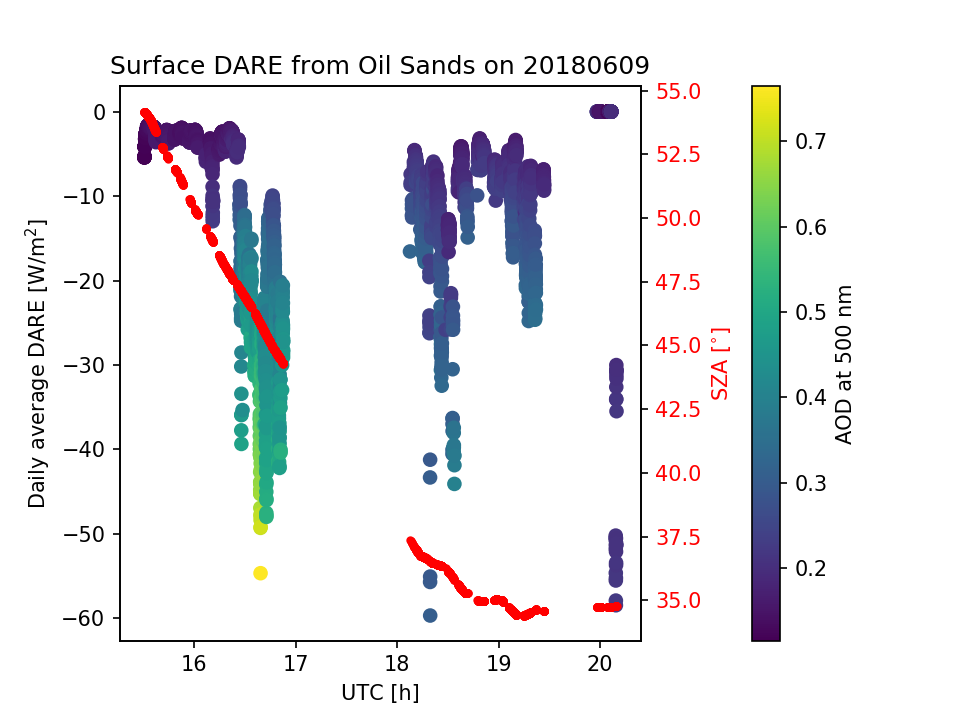

In [669]:
plt.figure()
plt.scatter(out['utc'][:],out['dare_avg'][:,0],c=out['aod'][:,3])
plt.xlabel('UTC [h]')
plt.ylabel('Daily average DARE [W/m$^2$]')
ax2 = plt.gca().twinx()
ax2.plot(out['utc'],out['sza'],'.r')
ax2.set_ylabel('SZA [$^{{\\circ}}$]',color='r')
ax2.tick_params(axis='y', labelcolor='r')
cb = plt.colorbar( pad=0.15)
cb.set_label('AOD at 500 nm')

plt.title('Surface DARE from Oil Sands on {}'.format(day))
plt.savefig(fp+'plots/DARE_avg_aod_utc_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


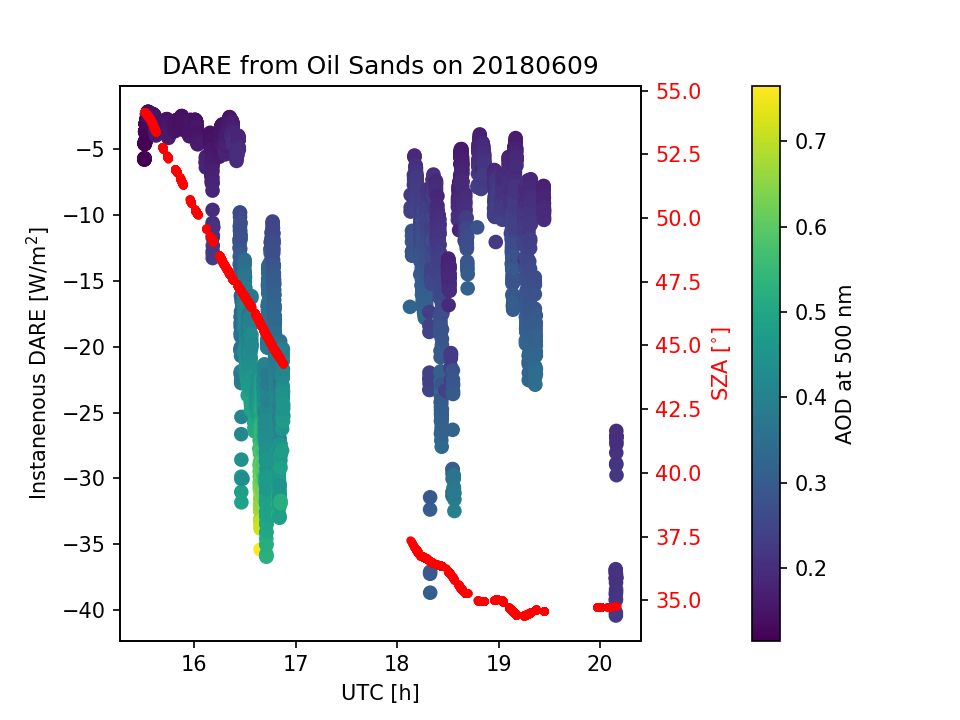

In [316]:
plt.figure()
plt.scatter(out['utc'][:],out['dare'][:,24,0],c=out['aod'][:,3])
plt.xlabel('UTC [h]')
plt.ylabel('Instanenous DARE [W/m$^2$]')
ax2 = plt.gca().twinx()
ax2.plot(out['utc'],out['sza'],'.r')
ax2.set_ylabel('SZA [$^{{\\circ}}$]',color='r')
ax2.tick_params(axis='y', labelcolor='r')
cb = plt.colorbar( pad=0.15)
cb.set_label('AOD at 500 nm')

plt.title('DARE from Oil Sands on {}'.format(day))
plt.savefig(fp+'plots/DARE_aod_utc_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


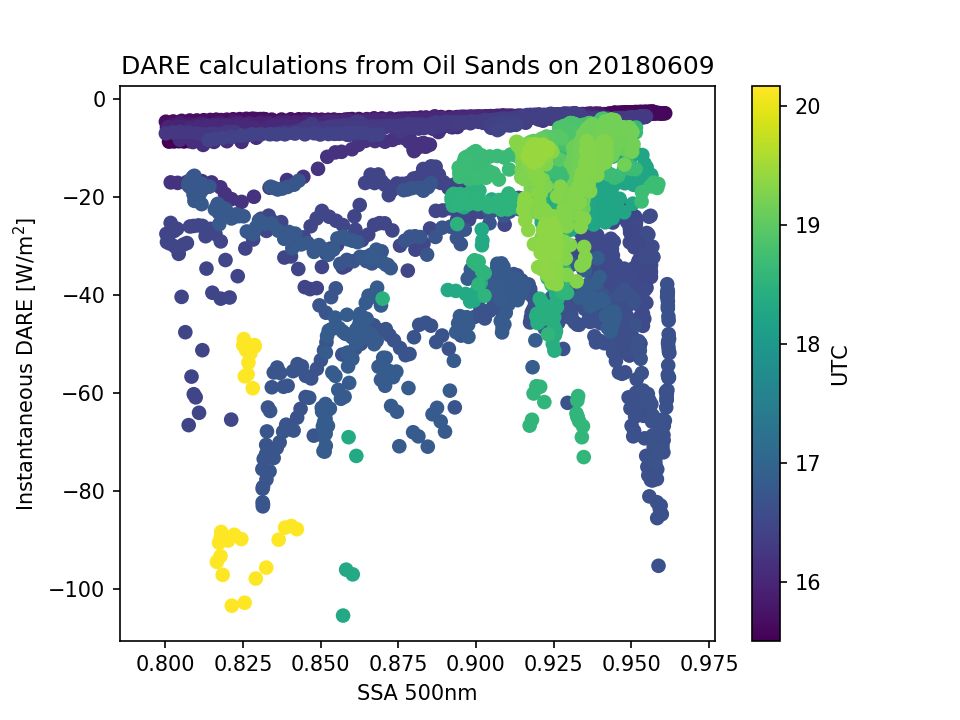

In [547]:
plt.figure()
plt.scatter(out['ssa'][:,0,3],out['dare'][:,0],c=out['utc'])
cb = plt.colorbar()
cb.set_label('UTC')
plt.xlabel('SSA 500nm')
plt.ylabel('Instantaneous DARE [W/m$^2$]')
plt.title('DARE calculations from Oil Sands on {}'.format(day))

plt.savefig(fp+'plots/DARE_vs_SSA_{}.png'.format(day),dpi=600,transparent=True)

## Plot compared to UHSAS

In [548]:
fx_h = interp1d(uh['utc'],uh['nConc'],bounds_error=False)
nConc = fx_h(out['utc'])

<IPython.core.display.Javascript object>


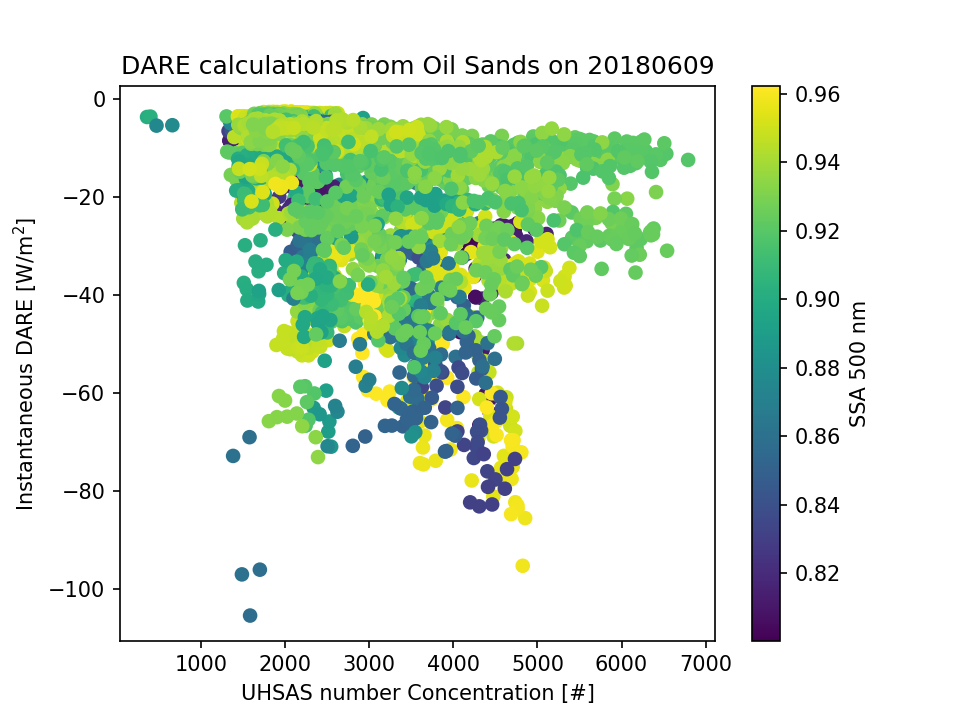

In [549]:
plt.figure()
plt.scatter(nConc,out['dare '][:,0],c=out['ssa'][:,0,3])
cb = plt.colorbar()
cb.set_label('SSA 500 nm')
plt.xlabel('UHSAS number Concentration [#]')
plt.ylabel('Instantaneous DARE [W/m$^2$]')
plt.title('DARE calculations from Oil Sands on {}'.format(day))
plt.savefig(fp+'plots/DARE_vs_nConc_UHSAS_{}.png'.format(day),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


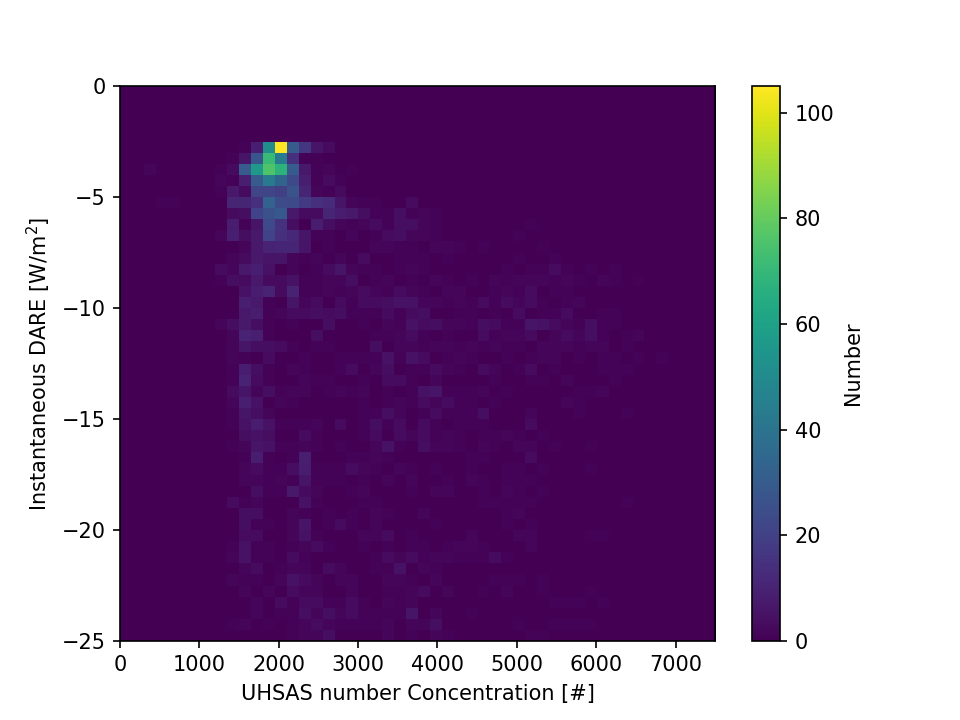

Text(0,0.5,'Instantaneous DARE [W/m$^2$]')

In [550]:
plt.figure()
plt.hist2d(nConc,out['dare'][:,0],range=[[0,7500],[-25,0]],bins=50)
plt.colorbar(label='Number')
plt.xlabel('UHSAS number Concentration [#]')
plt.ylabel('Instantaneous DARE [W/m$^2$]')

## Plot filtered for in plume

In [360]:
ipl = []
dare_pl = []
alt_pl = []
dare_out = []
alt_out = []
for ii, fo in enumerate(from_utc):
    pl = (out['utc']>=fo)&(out['utc']<=to_utc[ii])
    if pl.any():
        alt_pl = np.append(alt_pl,out['alt'][pl])
        dare_pl = np.append(dare_pl,out['dare_avg'][pl,0])
        ipl.append(pl)
    dare_out = np.append(dare_out,out['dare_avg'][~pl,0])
    alt_out = np.append(alt_out,out['alt'][~pl,0])

<IPython.core.display.Javascript object>


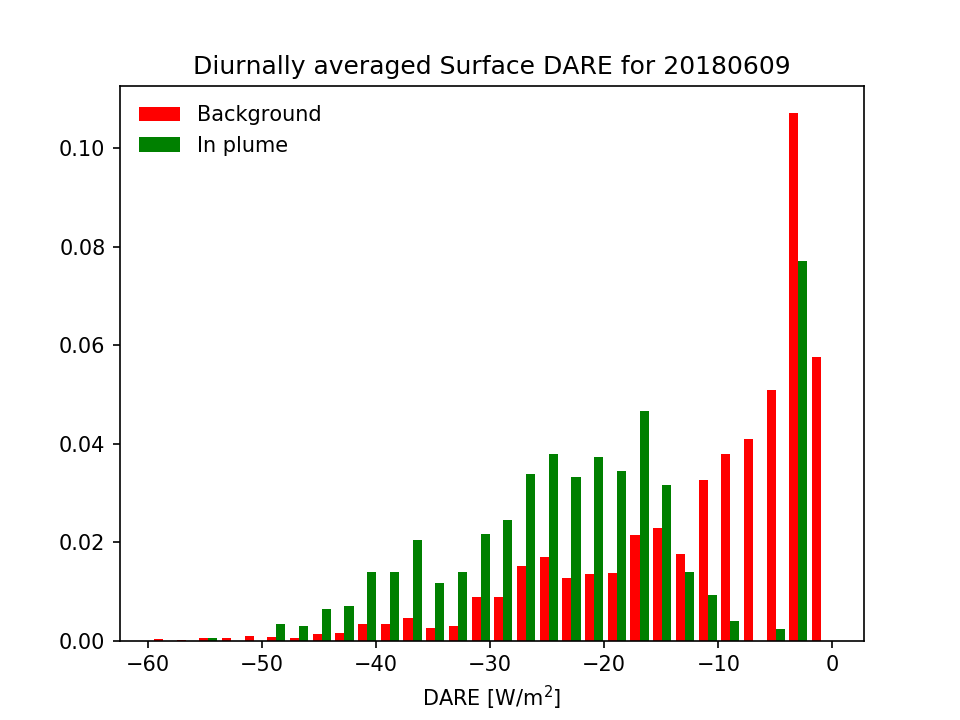

Text(0.5,1,'Diurnally averaged Surface DARE for 20180609')

In [635]:
plt.figure()
plt.hist([dare_out,dare_pl],color=['r','g'],label=['Background','In plume'],normed=True,bins=30)
plt.legend(frameon=False)
plt.xlabel('DARE [W/m$^2$]')
plt.title('Diurnally averaged Surface DARE for {}'.format(day))

In [688]:
ssa_u[1235]

nan

In [724]:
np.where(flag&np.isfinite(ssa_u))[0][367]

4105

In [690]:
out['ext'][367,:,3]

array([0.01638203, 0.01505487, 0.01535679, 0.01791146, 0.022398  ,
       0.01922707, 0.0192405 , 0.02020062, 0.02060542, 0.01639533,
       0.01531085, 0.01507887, 0.0157983 , 0.00893716, 0.        ])

In [692]:
out['z_aero']

array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6,
       1.7, 1.8])

In [693]:
out['ext'][367,:,3].sum()

0.2378972807710264

In [695]:
out['aod'][367,3]

0.1488338839171186

In [725]:
i = 4105

In [726]:
ext = expand_ext_vert_and_spect(ext_,ext_z,s['aod'][i,:],s['Alt'][i]/1000.0,wvl)

In [727]:
ext.shape

(15, 13)

In [728]:
ext[:,3].sum()

0.43545562042236396

In [729]:
s['aod'][i,3]

0.11441751994069706

In [705]:
out1['daystr'] = '20180609'
out2['daystr'] = '20180618'
out3['daystr'] = '20180624'
out4['daystr'] = '20180625'

<IPython.core.display.Javascript object>


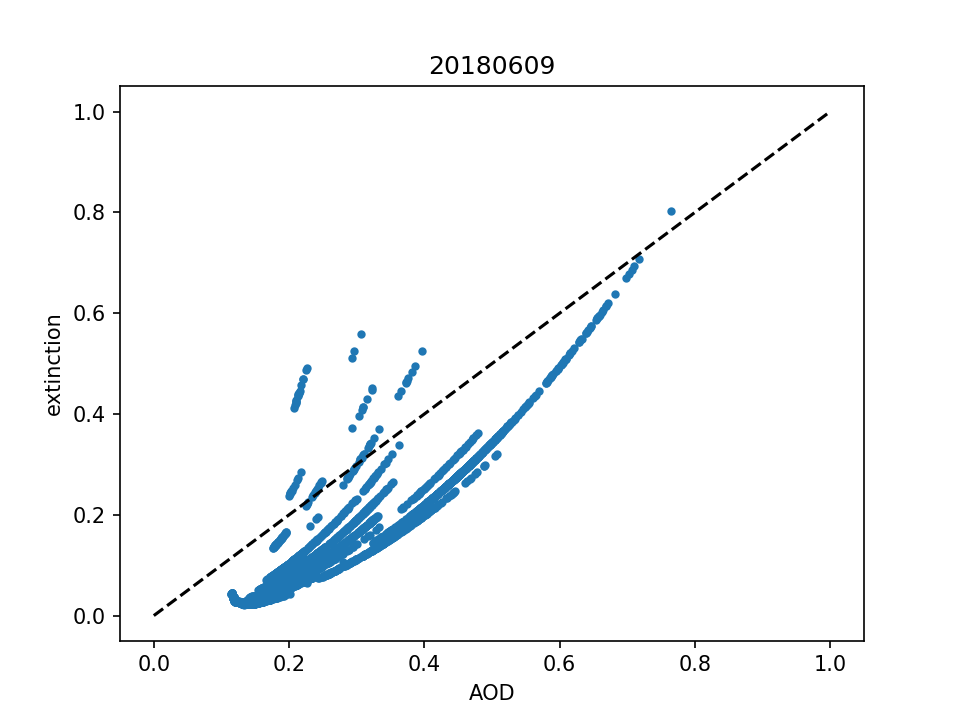

<IPython.core.display.Javascript object>


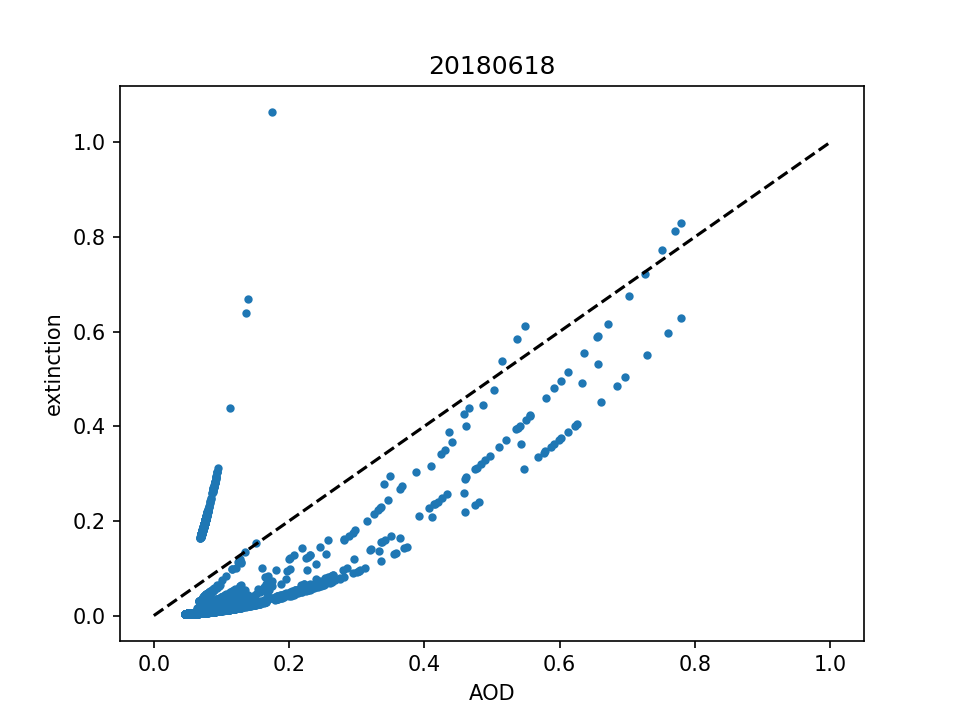

<IPython.core.display.Javascript object>


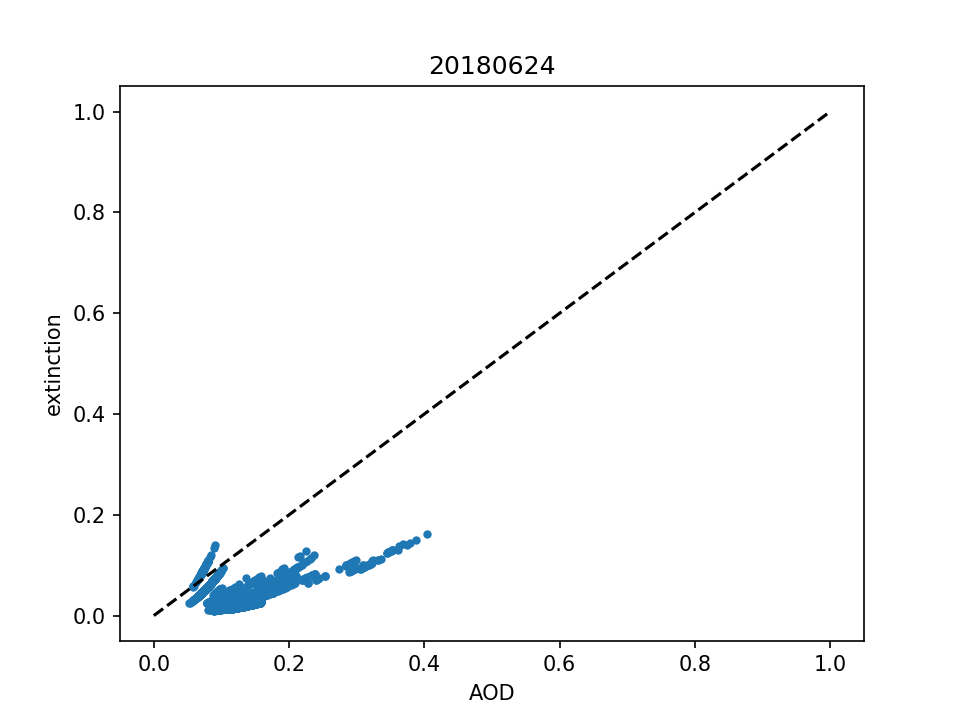

<IPython.core.display.Javascript object>


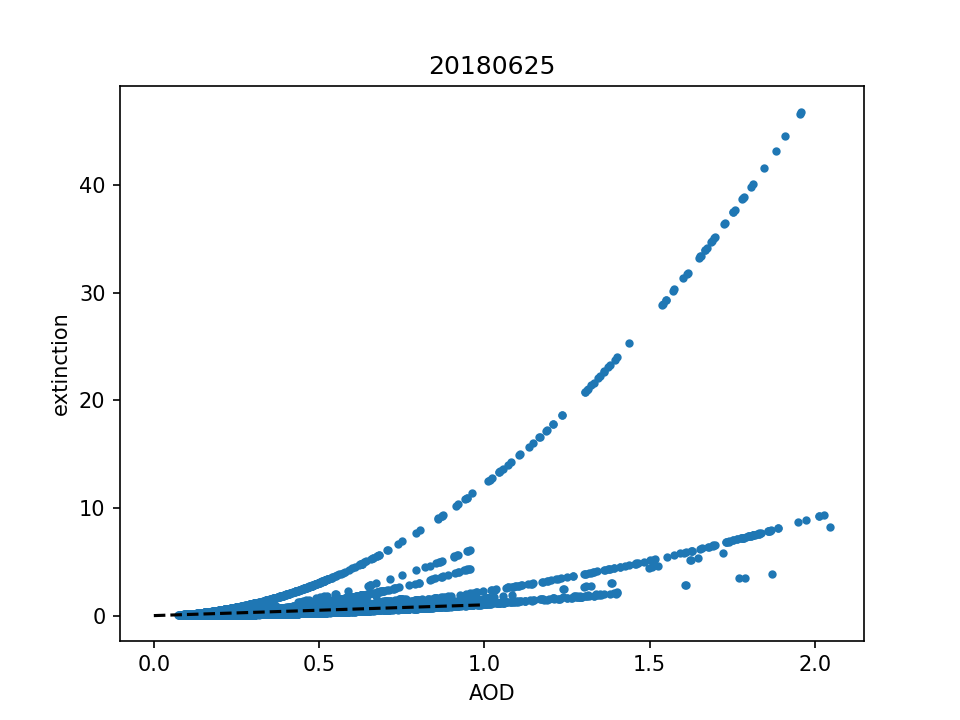

In [706]:
for outi in [out1,out2,out3,out4]:
    plt.figure()
    plt.plot(outi['aod'][:,3],outi['ext'][:,:,3].sum(axis=1)/10.0,'.')
    plt.plot([0,1],[0,1],'--k')
    plt.xlabel('AOD')
    plt.ylabel('extinction')
    plt.title('{}'.format(outi['daystr']))

<IPython.core.display.Javascript object>


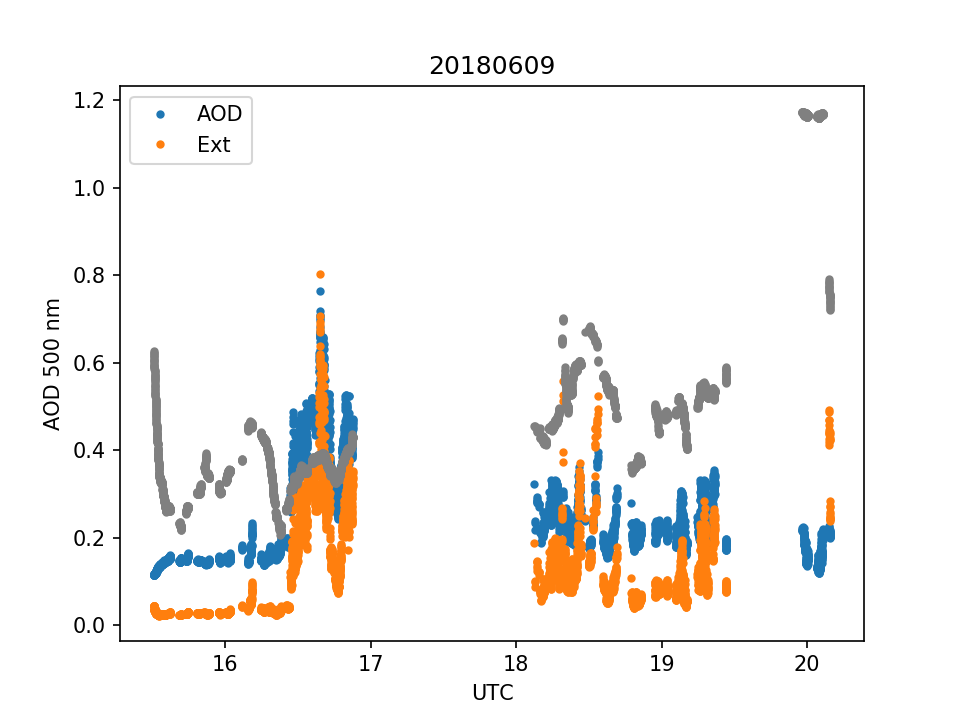

<IPython.core.display.Javascript object>


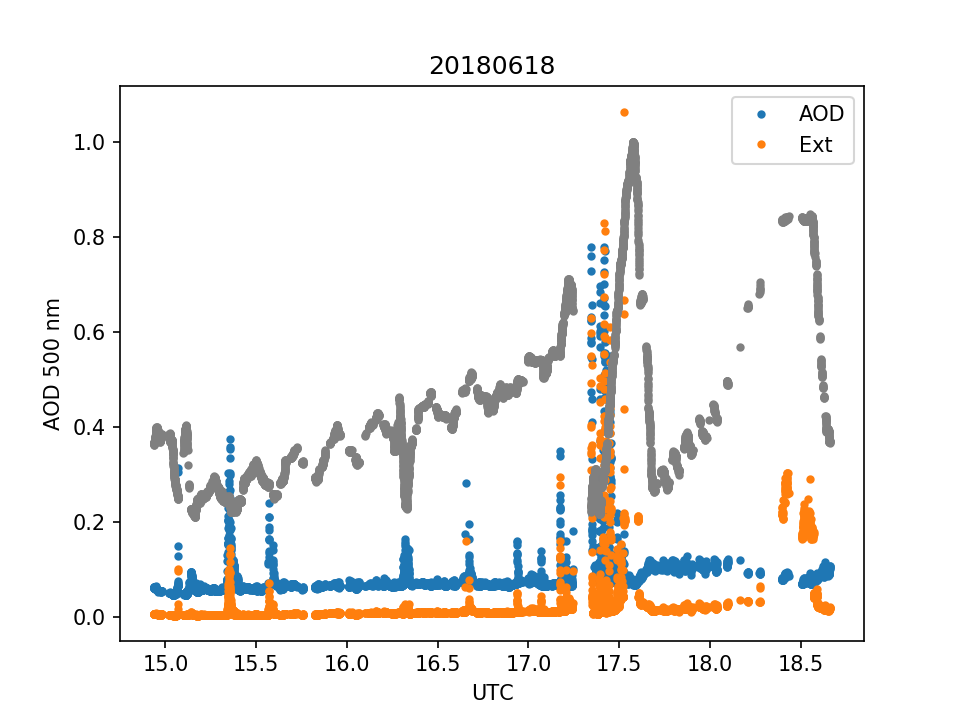

<IPython.core.display.Javascript object>


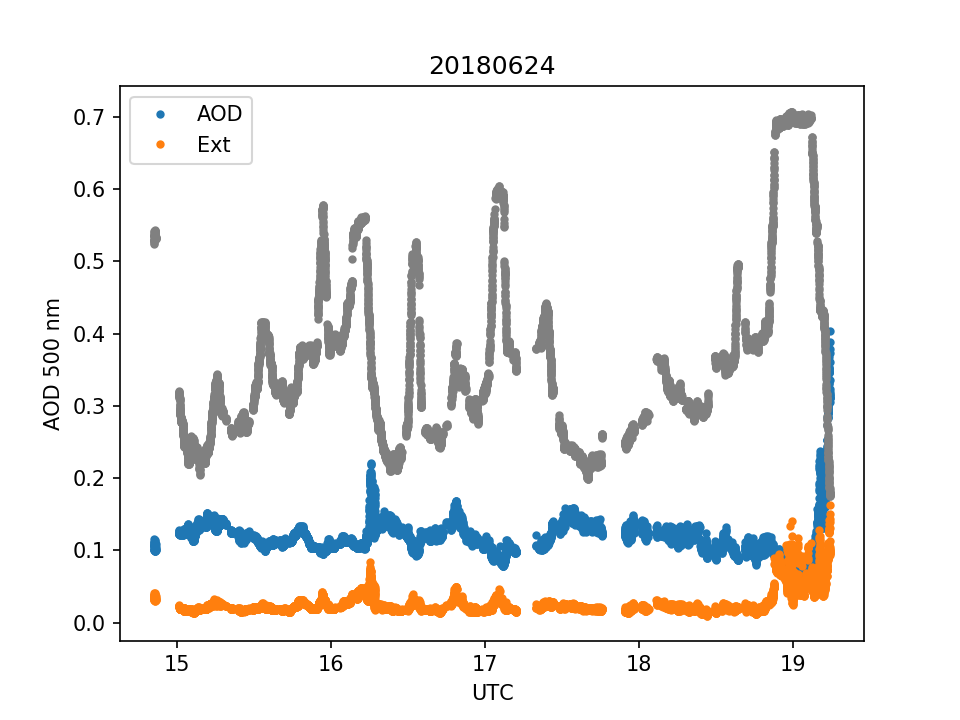

<IPython.core.display.Javascript object>


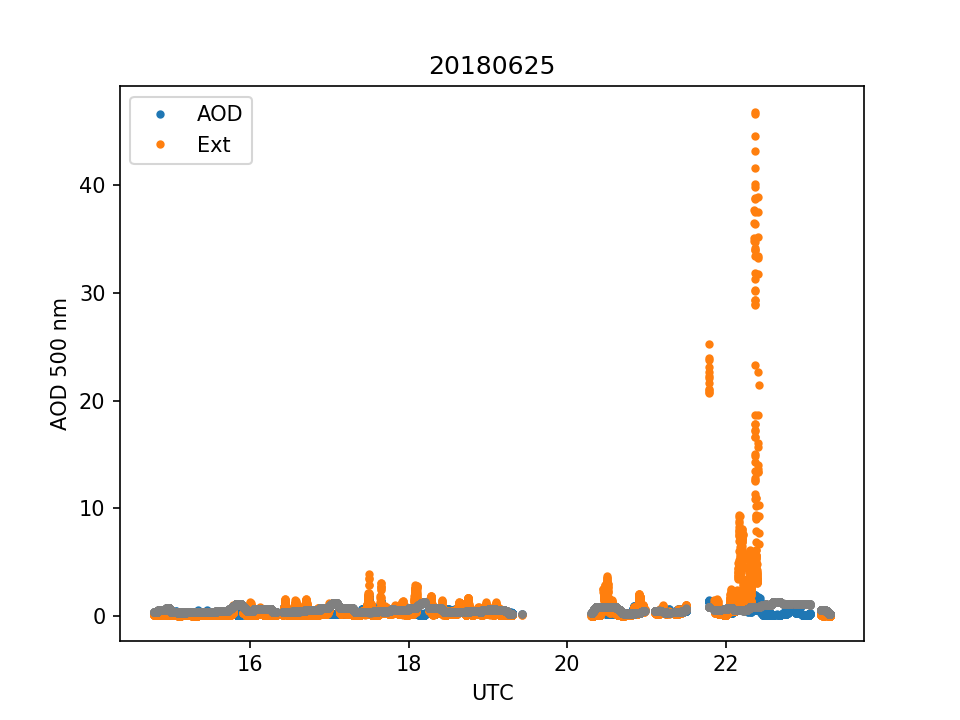

In [733]:
for outi in [out1,out2,out3,out4]:
    plt.figure()
    plt.plot(outi['utc'],outi['aod'][:,3],'.',label='AOD')
    plt.plot(outi['utc'],outi['ext'][:,:,3].sum(axis=1)/10.0,'.',label='Ext')
    plt.plot(outi['utc'],outi['alt']/2000.0,'.',color='grey')
    #plt.plot([0,1],[0,1],'--k')
    plt.xlabel('UTC')
    plt.ylabel('AOD 500 nm')
    plt.legend()
    plt.title('{}'.format(outi['daystr']))

# Combine the DARE calc for all days

In [ ]:
day = '20180609'
#day = '20180618'
#day = '20180624'
#day = '20180625'

In [370]:
out1 = hs.loadmat(fp+'{name}_DARE_{d}_{vv}.mat'.format(name=name,d='20180609',vv=vv))

In [372]:
out2 = hs.loadmat(fp+'{name}_DARE_{d}_{vv}.mat'.format(name=name,d='20180618',vv=vv))

In [373]:
out3 = hs.loadmat(fp+'{name}_DARE_{d}_{vv}.mat'.format(name=name,d='20180624',vv=vv))

In [374]:
out4 = hs.loadmat(fp+'{name}_DARE_{d}_{vv}.mat'.format(name=name,d='20180625',vv=vv))

## Get the time tables 

### 20180609

In [376]:
flttable1 = pd.read_excel(fp+'flt_table/fltable_{}.xlsx'.format('20180609'))
fromtime1 = flttable['FromTime'][flttable['FlightType']=='in plume']
totime1 = flttable['ToTime'][flttable['FlightType']=='in plume']

In [377]:
def time_utc(x):
    return np.array([y.hour+y.minute/60.0+y.second/3600.0 for y in x])

In [378]:
from_utc1 = time_utc(fromtime1.to_numpy())
to_utc1 = time_utc(totime1.to_numpy())

In [415]:
ipl1 = []
dare_pl1 = []
alt_pl1 = []
dare_out1 = []
alt_out1 = []
dare_pl1_toa, dare_out1_toa  = [],[]
for ii, fo in enumerate(from_utc1):
    pl1 = (out1['utc']>=fo)&(out1['utc']<=to_utc1[ii])
    if pl1.any():
        alt_pl1 = np.append(alt_pl1,out1['alt'][pl1])
        dare_pl1 = np.append(dare_pl1,out1['dare_avg'][pl1,0])
        dare_pl1_toa = np.append(dare_pl1_toa,out1['dare_avg'][pl1,2])
        ipl1.append(pl1)
    dare_out1 = np.append(dare_out1,out1['dare_avg'][~pl1,0])
    dare_out1_toa = np.append(dare_out1_toa,out1['dare_avg'][~pl1,2])
    alt_out1 = np.append(alt_out1,out1['alt'][~pl1,0])

In [636]:
out1.keys()

[u'dn_aero',
 u'aod',
 u'dn_clear',
 u'up_clear',
 u'utc',
 u'z_aero',
 u'asy',
 u'sza',
 u'lon',
 u'ext',
 u'dare_avg',
 u'zout',
 u'dare',
 u'wvl',
 u'lat',
 u'utcx',
 u'albedo',
 u'ssa',
 u'alt',
 u'up_aero']

In [643]:
ppl1 = np.array(ipl1).flatten()

<IPython.core.display.Javascript object>


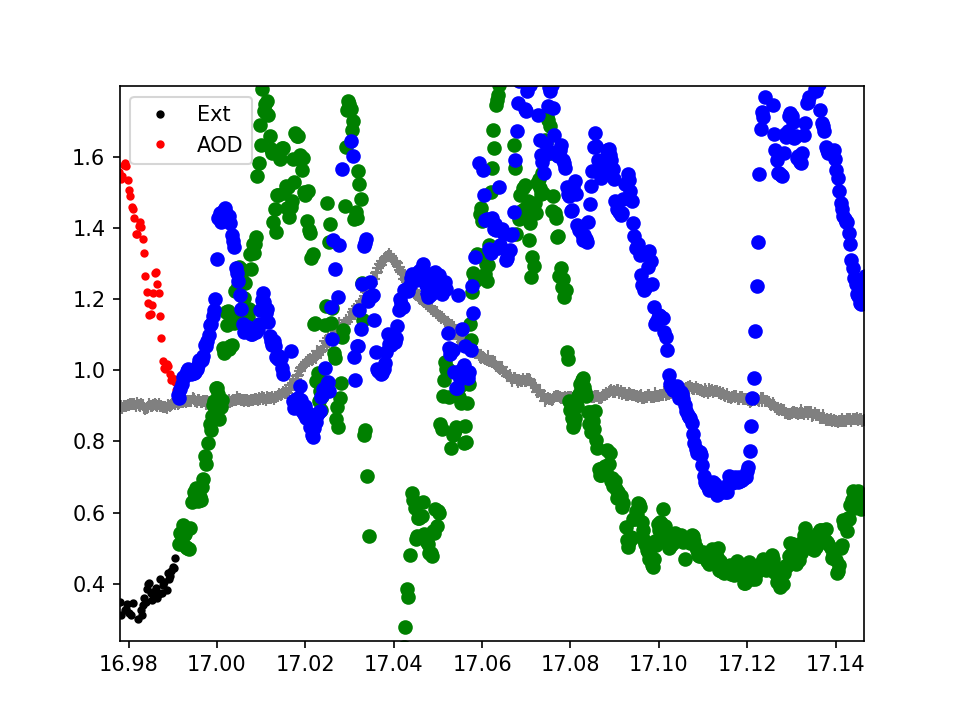

In [715]:
# Plot out the input extinction and aod
plt.figure()
plt.plot(insitu['utc'],insitu['extCalc500nm']/10.0,'.k',label='Ext')
plt.plot(s['utc'],s['tau_aero'][:,400],'.r',label='AOD')
plt.plot(s['utc'],s['Alt']/1000.0,'+',color='grey')
plt.legend()
for ii, fo in enumerate(from_utc1):
    plsitu = (insitu['utc']>=fo)&(insitu['utc']<=to_utc1[ii])
    if plsitu.any():
        plt.plot(insitu['utc'][plsitu],insitu['extCalc500nm'][plsitu]/10.0,'og')
    plaod = (s['utc']>=fo)&(s['utc']<=to_utc1[ii])
    if plaod.any():
        plt.plot(s['utc'][plaod],s['tau_aero'][plaod,400],'ob')
    
    plaodf = (s['utc'][flag]>=fo)&(s['utc'][flag]<=to_utc1[ii])
    if plaod.any():
        plt.plot(s['utc'][flag][plaodf],s['tau_aero'][flag,400][plaodf],'xc')
    
    
        

<IPython.core.display.Javascript object>


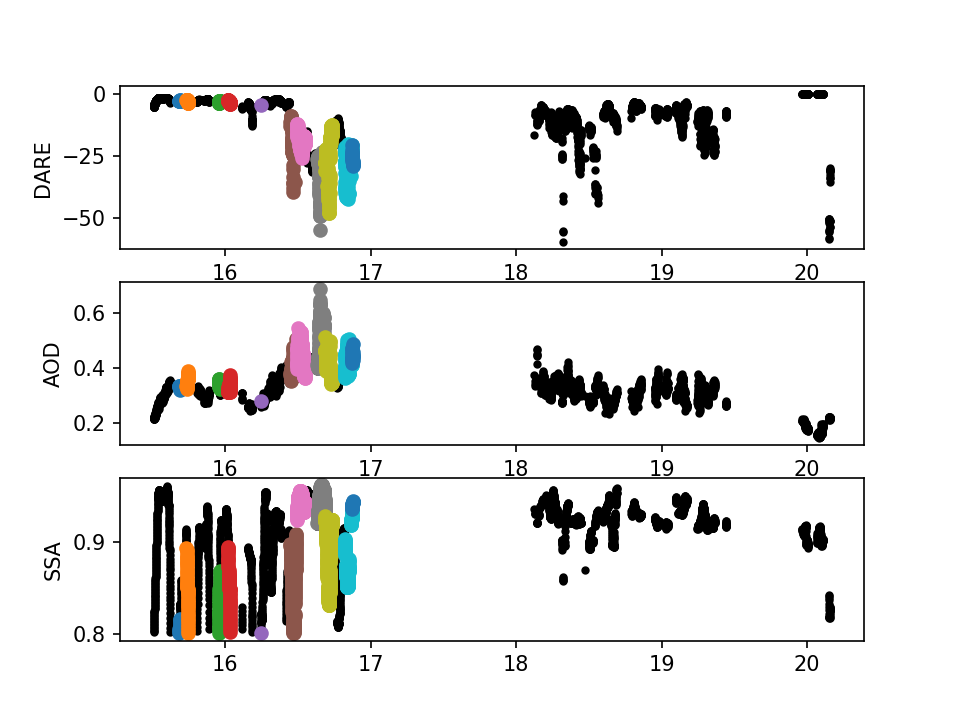

Text(0,0.5,'SSA')

In [658]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(out1['utc'],out1['dare_avg'][:,0],'.k',label='all')
for ipp in ipl1:
    ax1.plot(out1['utc'][ipp],out1['dare_avg'][ipp,0],'o')
ax1.set_ylabel('DARE')
    
ax2 = fig.add_subplot(312,sharex = ax1)
ax2.plot(out1['utc'],out1['aod'][:,0],'.k',label='all')
for ipp in ipl1:
    ax2.plot(out1['utc'][ipp],out1['aod'][ipp,0],'o')
ax2.set_ylabel('AOD')
    
ax3 = fig.add_subplot(313,sharex = ax1)
ax3.plot(out1['utc'],out1['ssa'][:,2,3],'.k',label='all')
for ipp in ipl1:
    ax3.plot(out1['utc'][ipp],out1['ssa'][ipp,2,3],'o')
ax3.set_ylabel('SSA')

In [677]:
out1['ext'].shape

(4255, 15, 13)

### 20180618

In [380]:
flttable2 = pd.read_excel(fp+'flt_table/fltable_{}.xlsx'.format('20180618'))
fromtime2 = flttable2['FromTime'][flttable2['FlightType']=='in plume']
totime2 = flttable2['ToTime'][flttable2['FlightType']=='in plume']

In [401]:
flttable2

YYYY   MM    DD  flNumNRC  flNumECCC   FlightType PlumeId Facility  \
0       NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
1       NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
2       NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
3       NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
4       NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
5    2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
6    2018.0  6.0  18.0      33.0       19.0    spiral up     NaN        A   
7    2018.0  6.0  18.0      33.0       19.0  spiral down     NaN        A   
8    2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
9    2018.0  6.0  18.0      33.0       19.0     in plume       A        A   
10   2018.0  6.0  18.0      33.0       19.0     in plume       B        A   
11   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
12      NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
13   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
14   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
15   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
16   2018.0  6.0  18.0      33.0       19.0     in plume       A        A   
17   2018.0  6.0  18.0      33.0       19.0     in plume       B        A   
18   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
19   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
20      NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
21   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
22   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
23   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
24   2018.0  6.0  18.0      33.0       19.0     in plume       A        A   
25   2018.0  6.0  18.0      33.0       19.0     in plume       B        A   
26   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
27   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
28      NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
29   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
..      ...  ...   ...       ...        ...          ...     ...      ...   
92   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
93   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
94   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
95   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
96   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
97   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
98   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
99   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
100  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
101  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
102  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
103  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
104  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
105  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
106  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
107  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
108  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
109  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
110  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
111  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
112

In [381]:
from_utc2 = time_utc(fromtime2.to_numpy())
to_utc2 = time_utc(totime2.to_numpy())

In [417]:
ipl2 = []
dare_pl2 = []
alt_pl2 = []
dare_out2 = []
alt_out2 = []
dare_pl2_toa, dare_out2_toa  = [],[]
for ii, fo in enumerate(from_utc2):
    pl2 = (out2['utc']>=fo)&(out2['utc']<=to_utc2[ii])
    if pl2.any():
        alt_pl2 = np.append(alt_pl2,out2['alt'][pl2])
        dare_pl2 = np.append(dare_pl2,out2['dare_avg'][pl2[:-1],0])
        dare_pl2_toa = np.append(dare_pl2_toa,out2['dare_avg'][pl2[:-1],2])
        ipl2.append(pl2)
    dare_out2 = np.append(dare_out2,out2['dare_avg'][~pl2[:-1],0])
    dare_out2_toa = np.append(dare_out2_toa,out2['dare_avg'][~pl2[:-1],2])
    alt_out2 = np.append(alt_out2,out2['alt'][~pl2,0])

### 20180624

In [387]:
flttable3 = pd.read_excel(fp+'flt_table/fltable_{}.xlsx'.format('20180624'))
fromtime3 = flttable3['FromTime'][flttable3['FlightType']=='in plume']
totime3 = flttable3['ToTime'][flttable3['FlightType']=='in plume']

In [388]:
from_utc3 = time_utc(fromtime3.to_numpy())
to_utc3 = time_utc(totime3.to_numpy())

In [418]:
ipl3 = []
dare_pl3 = []
alt_pl3 = []
dare_out3 = []
alt_out3 = []
dare_pl3_toa, dare_out3_toa  = [],[]
for ii, fo in enumerate(from_utc3):
    pl3 = (out3['utc']>=fo)&(out3['utc']<=to_utc3[ii])
    if pl3.any():
        alt_pl3 = np.append(alt_pl3,out3['alt'][pl3])
        dare_pl3 = np.append(dare_pl3,out3['dare_avg'][pl3,0])
        dare_pl3_toa = np.append(dare_pl3_toa,out3['dare_avg'][pl3,2])
        ipl3.append(pl3)
    dare_out3 = np.append(dare_out3,out3['dare_avg'][~pl3,0])
    dare_out3_toa = np.append(dare_out3_toa,out3['dare_avg'][~pl3,0])
    alt_out3 = np.append(alt_out3,out3['alt'][~pl3,0])

### 20180625

In [391]:
flttable4 = pd.read_excel(fp+'flt_table/fltable_{}.xlsx'.format('20180625'))
fromtime4 = flttable4['FromTime'][flttable4['FlightType']=='in plume']
totime4 = flttable4['ToTime'][flttable4['FlightType']=='in plume']

In [392]:
from_utc4 = time_utc(fromtime4.to_numpy())
to_utc4 = time_utc(totime4.to_numpy())

In [419]:
ipl4 = []
dare_pl4 = []
alt_pl4 = []
dare_out4 = []
alt_out4 = []
dare_pl4_toa, dare_out4_toa  = [],[]
for ii, fo in enumerate(from_utc4):
    pl4 = (out4['utc']>=fo)&(out4['utc']<=to_utc4[ii])
    if pl4.any():
        alt_pl4 = np.append(alt_pl4,out4['alt'][pl4])
        dare_pl4 = np.append(dare_pl4,out4['dare_avg'][pl4,0])
        dare_pl4_toa = np.append(dare_pl4_toa,out4['dare_avg'][pl4,0])
        ipl4.append(pl4)
    dare_out4 = np.append(dare_out4,out4['dare_avg'][~pl4,0])
    dare_out4_toa = np.append(dare_out4_toa,out4['dare_avg'][~pl4,0])
    alt_out4 = np.append(alt_out4,out4['alt'][~pl4,0])

## Plot the DAREs

In [412]:
fp

u'/data/sam/COSR/'

<IPython.core.display.Javascript object>


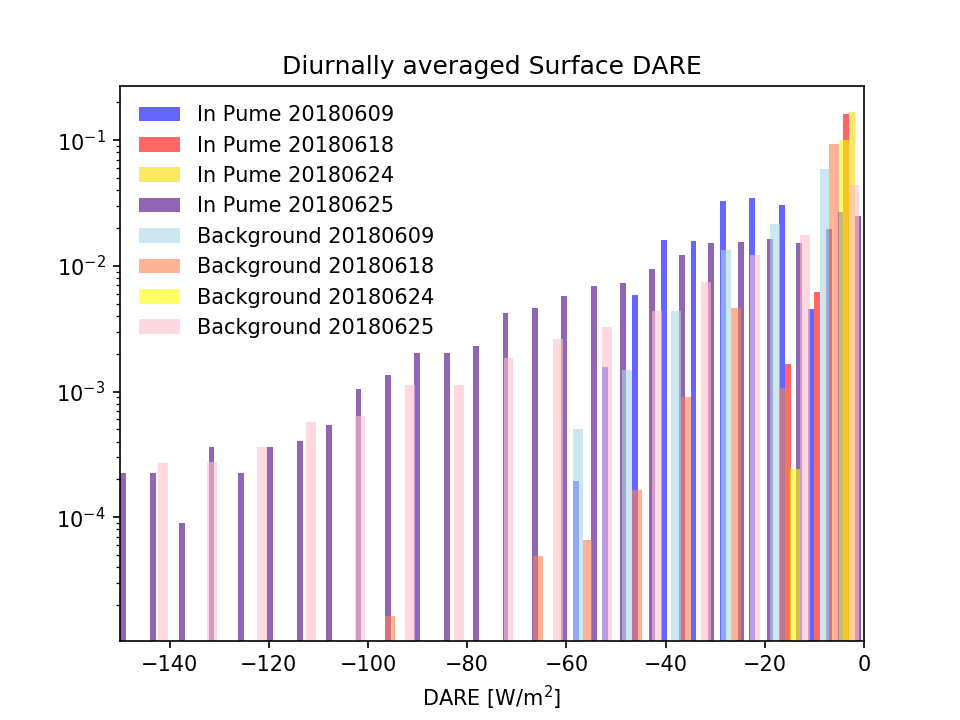

In [414]:
plt.figure()
plt.hist([dare_pl1,dare_pl2,dare_pl3,dare_pl4],color=['b','r','gold','indigo'],
         label=['In Pume 20180609','In Pume 20180618','In Pume 20180624','In Pume 20180625'],normed=True,bins=30,alpha=0.6)
plt.hist([dare_out1,dare_out2,dare_out3,dare_out4],color=['lightblue','coral','yellow','pink'],
         label=['Background 20180609','Background 20180618','Background 20180624','Background 20180625'],
         normed=True,bins=30,alpha=0.6)
plt.xlim(-150,0)
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('DARE [W/m$^2$]')
plt.title('Diurnally averaged Surface DARE')
plt.savefig(fp+'plots/DARE_avg_inplume_out_COSR.png',transparent=True,dpi=600)

<IPython.core.display.Javascript object>


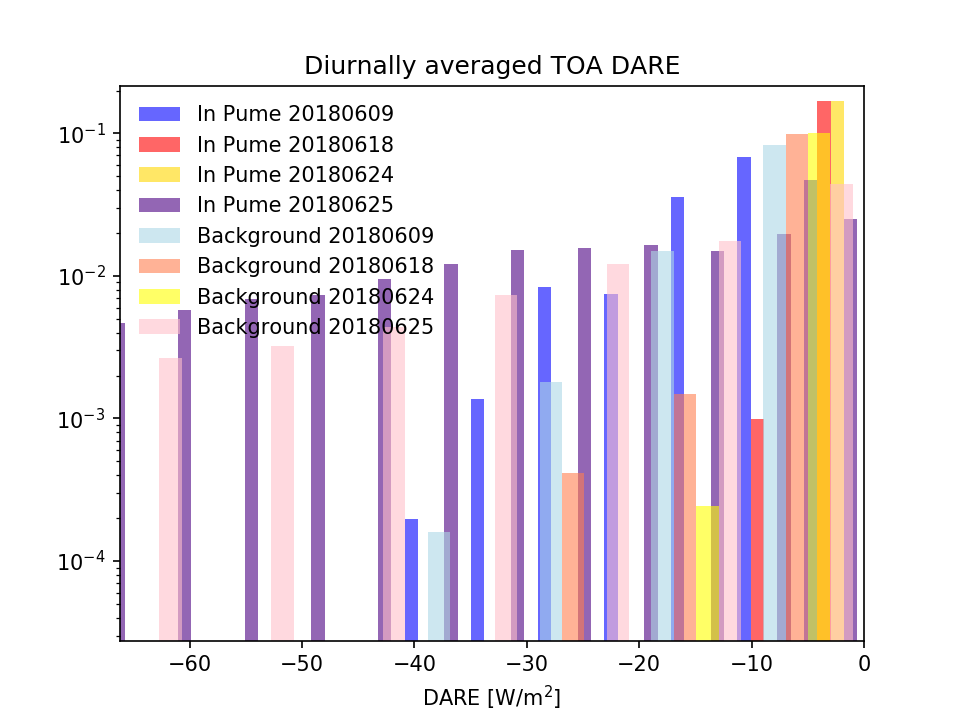

In [421]:
plt.figure()
plt.hist([dare_pl1_toa,dare_pl2_toa,dare_pl3_toa,dare_pl4_toa],color=['b','r','gold','indigo'],
         label=['In Pume 20180609','In Pume 20180618','In Pume 20180624','In Pume 20180625'],normed=True,bins=30,alpha=0.6)
plt.hist([dare_out1_toa,dare_out2_toa,dare_out3_toa,dare_out4_toa],color=['lightblue','coral','yellow','pink'],
         label=['Background 20180609','Background 20180618','Background 20180624','Background 20180625'],
         normed=True,bins=30,alpha=0.6)
plt.xlim(-150,0)
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('DARE [W/m$^2$]')
plt.title('Diurnally averaged TOA DARE')
plt.savefig(fp+'plots/DARE_avg_inplume_out_COSR_TOA.png',transparent=True,dpi=600)

In [406]:
np.nanmean(dare_pl1),np.nanmean(dare_pl2),np.nanmean(dare_pl3),np.nanmean(dare_pl4)

(-21.66743838246268,
 -1.5546438983625734,
 -1.6284513862157686,
 -32.259184600165725)

In [407]:
np.nanmedian(dare_pl1),np.nanmedian(dare_pl2),np.nanmedian(dare_pl3),np.nanmedian(dare_pl4)

(-21.56366102229167,
 -0.8225490857142947,
 -1.6005396770833338,
 -26.777597985645833)

In [408]:
np.nanstd(dare_pl1),np.nanstd(dare_pl2),np.nanstd(dare_pl3),np.nanstd(dare_pl4)

(11.483013744563303,
 2.020551737022134,
 0.25924101865136556,
 26.932736238771025)

In [409]:
np.nanmean(dare_out1),np.nanmean(dare_out2),np.nanmean(dare_out3),np.nanmean(dare_out4)

(-11.223490255448569,
 -3.1603512821298496,
 -2.283641030871713,
 -27.275655916797813)

In [410]:
np.nanmedian(dare_out1),np.nanmedian(dare_out2),np.nanmedian(dare_out3),np.nanmedian(dare_out4)

(-7.7583685166666685,
 -1.2181338857143056,
 -1.7868755625000092,
 -12.762458835416666)

In [411]:
np.nanstd(dare_out1),np.nanstd(dare_out2),np.nanstd(dare_out3),np.nanstd(dare_out4)

(10.474985189042815, 6.760096158681584, 1.3780882852693597, 42.85474214312306)